In [1]:
import os

import pandas as pd
import numpy as np
from time import time
from joblib import load, dump
from enum import Enum

from fire_modules import severity_matrix as sm

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

In [3]:
seed = 42

In [4]:
csv_path = os.path.join('data', 'fires_transformed.csv')
df = pd.read_csv(csv_path)
df.sample(5, random_state=seed)

,elevacion,erodi,slope,orientacion_sen,orientacion_cos,altura,lfcc,inflam,mcroth,anomalia,dpv,vel_media_viento,severidad_real,severidad_discreta,coord_x_etrs89,coord_y_etrs89,incendio,provincia
119340,1024.904053,4,15.177,0.994650,0.103298,9.0,46.956501,3,2,73.561211,2.246882,2.916394,0.845614,3,490110.0,4538190.0,Cogolludo,Guadalajara
58023,505.352997,1,25.718,0.206331,0.978482,3.0,19.892401,4,3,86.961823,2.385298,4.876472,0.270908,1,604950.0,4257480.0,Talave,Albacete
46997,388.710999,2,31.593,-0.984000,0.178167,1.0,0.956900,4,3,79.168137,2.319516,5.026659,0.412787,1,617730.0,4243860.0,Donceles,Albacete
67214,1063.177002,1,22.364,0.901304,-0.433188,2.0,7.424201,4,1,50.321835,0.349119,2.470344,0.576249,2,561090.0,4256790.0,Yeste,Albacete
153590,507.516998,3,13.911,0.872081,0.489362,3.0,32.275799,4,3,72.893860,1.469779,3.393716,0.310006,1,407340.0,4412550.0,Montesion,Toledo


In [5]:
numerical_variables = ['elevacion', 'slope', 'orientacion_sen', 'orientacion_cos', 'altura', 'lfcc', 'anomalia', 'dpv', 'vel_media_viento']
categorical_variables = ['erodi', 'inflam', 'mcroth']
variables = numerical_variables + categorical_variables
target_real = 'severidad_real'
target_discrete = 'severidad_discreta'

coords_columns = ['coord_x_etrs89', 'coord_y_etrs89']

In [6]:
def optimize_params(estimator, X, y, cv, scoring=None, refit=True, **param_grid):
    t = time()

    # GridSearch over specified parameter values for an estimator
    grid_search_cv = GridSearchCV(estimator,
                                  param_grid,
                                  scoring=scoring,
                                  refit=False,  # Disable automatic refit to manually select best estimator
                                  cv=cv,
                                  verbose=1,
                                  n_jobs=10,
                                  return_train_score=True).fit(X, y)

    cv_results = pd.DataFrame(grid_search_cv.cv_results_)   

    # Calculate weighted sizes of each fold
    sizes_train = []
    sizes_test = []
    for train_indexes, test_indexes in cv:
        sizes_train.append(len(train_indexes))
        sizes_test.append(len(test_indexes))
    total_sizes_train = sum(sizes_train)
    total_sizes_test = sum(sizes_test)
    weighted_sizes_train = [x / total_sizes_train for x in sizes_train]
    weighted_sizes_test = [x / total_sizes_test for x in sizes_test]

    # Calculate weighted mean score for train and test
    weighted_mean_train_score = sum(cv_results[f'split{i}_train_score'] * weighted_sizes_train[i] for i in range(len(weighted_sizes_train)))
    cv_results.insert(cv_results.columns.get_loc('mean_train_score'), 'weighted_mean_train_score', weighted_mean_train_score)
    weighted_mean_test_score = sum(cv_results[f'split{i}_test_score'] * weighted_sizes_test[i] for i in range(len(weighted_sizes_test)))
    cv_results.insert(cv_results.columns.get_loc('mean_test_score'), 'weighted_mean_test_score', weighted_mean_test_score)

    # Order params by the weighted mean test score
    cv_results = cv_results.sort_values(by='weighted_mean_test_score', ascending=False)
    cv_results['rank_test_score'] = range(1, len(cv_results) + 1)

    # Drop the results for each validation split
    labels = cv_results.filter(regex="split")
    cv_results = cv_results.drop(labels, axis=1)

    print(f'Time: {round(time()-t, 2)} seg.')
    display(cv_results)

    
    grid_search_cv.best_index_ = cv_results.index[0]
    grid_search_cv.best_params_ = cv_results.loc[grid_search_cv.best_index_, 'params']
    grid_search_cv.best_score_ = cv_results.loc[grid_search_cv.best_index_, 'weighted_mean_test_score']
    # Refit with best params
    if refit:
        grid_search_cv.best_estimator_ = grid_search_cv.estimator.set_params(**grid_search_cv.best_params_).fit(X, y)
    

    return grid_search_cv

In [7]:
preprocessing = make_column_transformer(
        (StandardScaler(), numerical_variables),
        (OneHotEncoder(handle_unknown='ignore'), categorical_variables),
        remainder='passthrough'
)

In [8]:
def reclass(new_classification, df):
    df_copy = df.copy()
    df_copy = df_copy[df_copy[target_discrete].isin(list(new_classification.keys()))].reset_index(drop=True)
    df_copy[target_discrete] = df_copy[target_discrete].map(new_classification, na_action='ignore')
    return df_copy

In [9]:
class Zona(Enum):
    AB_CU = ['Albacete', 'Cuenca']
    TO_CR_GU = ['Toledo', 'Ciudad Real', 'Guadalajara']


# Zona AB_CU

In [10]:
fire_names = list(df[df['provincia'].isin(Zona.AB_CU.value)]['incendio'].unique())
test_fire_names = ['Agramon', 'Almansa']
train_fire_names = [x for x in fire_names if x not in test_fire_names]

print(f'Train: {train_fire_names}')
print(f'Test:  {test_fire_names}')

Train: ['Donceles', 'Lietor', 'Talave', 'Yeste', 'Cañada_del_Hoyo']
Test:  ['Agramon', 'Almansa']


In [11]:
df_train = df[df['incendio'].isin(train_fire_names)].reset_index(drop=True)
print(len(df_train))
df_train.head()

88048


,elevacion,erodi,slope,orientacion_sen,orientacion_cos,altura,lfcc,inflam,mcroth,anomalia,dpv,vel_media_viento,severidad_real,severidad_discreta,coord_x_etrs89,coord_y_etrs89,incendio,provincia
0,474.993988,1,2.988,0.591536,0.806278,4.0,13.578500,4,3,78.942978,2.530710,5.199876,0.153908,0,607110.0,4256310.0,Donceles,Albacete
1,472.980011,1,2.177,0.997200,0.074776,8.0,10.838201,4,3,78.941406,2.531341,5.200114,0.174595,0,607140.0,4256310.0,Donceles,Albacete
2,466.144989,1,7.510,0.977572,-0.210601,9.0,17.604599,4,3,78.936714,2.533220,5.200821,0.176796,0,607230.0,4256310.0,Donceles,Albacete
3,475.859985,1,3.765,0.762302,0.647222,4.0,14.039700,4,3,78.944611,2.529883,5.199497,0.168421,0,607110.0,4256280.0,Donceles,Albacete
4,473.007996,1,3.792,0.986111,0.166089,4.0,16.137899,4,3,78.943054,2.530514,5.199735,0.202057,0,607140.0,4256280.0,Donceles,Albacete


In [12]:
df_test = df[df['incendio'].isin(test_fire_names)].reset_index(drop=True)
print(len(df_test))
df_test.head()

4518


,elevacion,erodi,slope,orientacion_sen,orientacion_cos,altura,lfcc,inflam,mcroth,anomalia,dpv,vel_media_viento,severidad_real,severidad_discreta,coord_x_etrs89,coord_y_etrs89,incendio,provincia
0,482.423004,1,15.401000,0.091827,0.995775,10.0,13.2000,3,3,80.210800,1.464469,2.855457,0.155662,0,615180.0,4257300.0,Agramon,Albacete
1,487.563995,1,20.632999,0.087687,0.996148,1.0,0.7326,3,3,80.228157,1.463829,2.855017,0.224380,0,614850.0,4257270.0,Agramon,Albacete
2,486.273987,1,12.380000,-0.129868,0.991531,1.0,5.1383,3,3,80.207359,1.464057,2.855563,0.308407,1,615120.0,4257270.0,Agramon,Albacete
3,495.325989,1,21.625000,0.222399,0.974956,1.0,1.4184,3,3,80.210716,1.463563,2.855489,0.207618,0,614970.0,4257240.0,Agramon,Albacete
4,490.188995,1,19.408001,-0.010958,0.999940,4.0,7.4510,3,3,80.206093,1.463614,2.855611,0.292563,1,615030.0,4257240.0,Agramon,Albacete


## Baja - Alta

In [13]:
new_classification = {0:0, 1:0, 2:1, 3:1}

df_train_reclass = reclass(new_classification, df_train)
df_test_reclass = reclass(new_classification, df_test)

In [14]:
X_train = df_train_reclass[variables]
y_train = df_train_reclass[target_discrete]

X_test = df_test_reclass[variables]
y_test = df_test_reclass[target_discrete]

In [15]:
folds = []

for name in train_fire_names:
    fold_train_names = [x for x in train_fire_names if x != name]
    fold_test_name = [x for x in train_fire_names if x == name]

    fold_train_indices = df_train_reclass[(df_train_reclass['incendio'].isin(fold_train_names))].index
    fold_test_indices = df_train_reclass[df_train_reclass['incendio'].isin(fold_test_name)].index
    folds.append((fold_train_indices, fold_test_indices))

[print(f'Fold {i}: Train: {x.size}\tTest:{y.size}') for i, (x, y) in enumerate(folds)];

Fold 0: Train: 44837	Test:43211
Fold 1: Train: 81916	Test:6132
Fold 2: Train: 79397	Test:8651
Fold 3: Train: 60978	Test:27070
Fold 4: Train: 85064	Test:2984


### Grid Search

#### Logistic Regression

In [16]:
poly = PolynomialFeatures(include_bias=False)
logistic_reg = LogisticRegression(random_state=seed)
logistic_reg_pipeline = make_pipeline(preprocessing, poly, logistic_reg)

param_grid = {
    'polynomialfeatures__degree': [1, 2],
    'logisticregression__C': [0.01, 0.1, 1, 2, 5, 10],
    'logisticregression__max_iter': [100, 200]
}

logistic_reg_gs = optimize_params(logistic_reg_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Time: 72.2 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__max_iter,param_polynomialfeatures__degree,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
3,12.581760,3.446838,0.102133,0.072840,0.01,200,2,"{'logisticregression__C': 0.01, 'logisticregre...",0.279116,0.234977,0.212433,1,0.613411,0.616904,0.032299
1,6.645056,1.540839,0.109761,0.086880,0.01,100,2,"{'logisticregression__C': 0.01, 'logisticregre...",0.276766,0.236804,0.211521,2,0.613490,0.616999,0.032064
5,6.607081,1.625180,0.106829,0.077009,0.1,100,2,"{'logisticregression__C': 0.1, 'logisticregres...",0.261599,0.262618,0.293753,3,0.617506,0.621151,0.030918
7,12.846117,3.071219,0.114709,0.084010,0.1,200,2,"{'logisticregression__C': 0.1, 'logisticregres...",0.260285,0.256382,0.286865,4,0.617538,0.621086,0.030564
11,13.008638,3.151030,0.112022,0.084062,1,200,2,"{'logisticregression__C': 1, 'logisticregressi...",0.252900,0.256604,0.286938,5,0.620448,0.623991,0.028636
19,12.558689,2.920727,0.108164,0.095070,5,200,2,"{'logisticregression__C': 5, 'logisticregressi...",0.251835,0.254709,0.283090,6,0.620402,0.623958,0.028364
23,7.713383,0.883931,0.054541,0.046965,10,200,2,"{'logisticregression__C': 10, 'logisticregress...",0.251536,0.255034,0.286305,7,0.620343,0.623852,0.027707
9,6.614572,1.598248,0.117667,0.089300,1,100,2,"{'logisticregression__C': 1, 'logisticregressi...",0.251325,0.260935,0.295594,8,0.618037,0.621760,0.030729
15,12.704830,2.933852,0.125710,0.101437,2,200,2,"{'logisticregression__C': 2, 'logisticregressi...",0.251293,0.256540,0.294301,9,0.620207,0.623776,0.028822
13,6.731250,1.648340,0.128906,0.105495,2,100,2,"{'logisticregression__C': 2, 'logisticregressi...",0.251028,0.257521,0.292268,10,0.617709,0.621407,0.030965


c:\Users\Alejandro.Martinez\AppData\Local\miniconda3\envs\nuevoEntorno\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### KNeighbors

In [17]:
k_neighbors_class = KNeighborsClassifier()
k_neighbours_class_pipeline = make_pipeline(preprocessing, k_neighbors_class)

param_grid = {
    'kneighborsclassifier__n_neighbors': [5, 10, 20, 50, 100],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}

k_neighbors_class_gs = optimize_params(k_neighbours_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Time: 363.48 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,param_kneighborsclassifier__weights,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
0,0.094468,0.017014,11.019151,7.306364,5,uniform,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.262815,0.234943,0.081457,1,0.752396,0.754858,0.023863
1,0.102550,0.017376,11.190759,7.207277,5,distance,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.262774,0.234926,0.081459,2,1.000000,1.000000,0.000000
3,0.070286,0.011529,10.967528,7.283043,10,distance,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.246041,0.217094,0.083649,3,1.000000,1.000000,0.000000
5,0.067112,0.015274,11.089795,7.197760,20,distance,"{'kneighborsclassifier__n_neighbors': 20, 'kne...",0.223212,0.194226,0.102266,4,1.000000,1.000000,0.000000
7,0.070043,0.008606,11.861816,8.174742,50,distance,"{'kneighborsclassifier__n_neighbors': 50, 'kne...",0.218032,0.191113,0.115743,5,1.000000,1.000000,0.000000
9,0.063813,0.014213,12.493296,8.545294,100,distance,"{'kneighborsclassifier__n_neighbors': 100, 'kn...",0.217664,0.195929,0.120592,6,1.000000,1.000000,0.000000
8,0.059519,0.011422,12.525888,8.544546,100,uniform,"{'kneighborsclassifier__n_neighbors': 100, 'kn...",0.214578,0.193215,0.121494,7,0.643268,0.646244,0.036226
6,0.063474,0.014777,11.646032,7.701969,50,uniform,"{'kneighborsclassifier__n_neighbors': 50, 'kne...",0.211552,0.184784,0.116566,8,0.657522,0.660426,0.034543
2,0.073844,0.017060,12.083043,7.994644,10,uniform,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.210342,0.182504,0.088072,9,0.693123,0.696349,0.031608
4,0.057894,0.014691,10.942424,6.961068,20,uniform,"{'kneighborsclassifier__n_neighbors': 20, 'kne...",0.206304,0.177098,0.104915,10,0.675907,0.679097,0.032709


#### Decision Tree

In [18]:
decision_tree_class = DecisionTreeClassifier(random_state=seed)
decision_tree_class_pipeline = make_pipeline(preprocessing, decision_tree_class)

param_grid = {
    'decisiontreeclassifier__max_depth': [3, 5, 7, 10, None],
    'decisiontreeclassifier__min_samples_split': [2, 50, 200],
    'decisiontreeclassifier__criterion': ['entropy', 'gini'],
    'decisiontreeclassifier__ccp_alpha': [0, 0.0001, 0.001, 0.01, 0.1]
}

decision_tree_class_gs = optimize_params(decision_tree_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Time: 163.53 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__ccp_alpha,param_decisiontreeclassifier__criterion,param_decisiontreeclassifier__max_depth,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
27,3.605676,0.853545,0.023026,0.014423,0,gini,None,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.347322,0.278272,0.132708,1,1.000000,1.000000,0.000000
28,3.328887,0.795890,0.021455,0.016237,0,gini,None,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.320509,0.269573,0.162627,2,0.829910,0.831715,0.028756
12,4.140234,1.018650,0.021164,0.007880,0,entropy,None,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.284627,0.231587,0.103254,3,1.000000,1.000000,0.000000
58,3.344098,0.805360,0.019968,0.010257,0.0001,gini,None,"{'decisiontreeclassifier__ccp_alpha': 0.0001, ...",0.257428,0.197025,0.152004,4,0.772064,0.776737,0.047755
10,2.804013,0.631619,0.023850,0.016215,0,entropy,10,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.248087,0.215611,0.085293,5,0.705555,0.708959,0.033367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,1.715225,0.349645,0.021541,0.012108,0.01,gini,7,"{'decisiontreeclassifier__ccp_alpha': 0.01, 'd...",0.000000,0.000000,0.000000,146,0.378726,0.399790,0.261869
112,1.713411,0.361648,0.019590,0.010236,0.01,gini,7,"{'decisiontreeclassifier__ccp_alpha': 0.01, 'd...",0.000000,0.000000,0.000000,147,0.378726,0.399790,0.261869
113,1.708162,0.374792,0.023550,0.015811,0.01,gini,7,"{'decisiontreeclassifier__ccp_alpha': 0.01, 'd...",0.000000,0.000000,0.000000,148,0.378726,0.399790,0.261869
114,2.330711,0.554216,0.023965,0.016109,0.01,gini,10,"{'decisiontreeclassifier__ccp_alpha': 0.01, 'd...",0.000000,0.000000,0.000000,149,0.378726,0.399790,0.261869


#### Random Forest

In [19]:
random_forest_class = RandomForestClassifier(random_state=seed)
random_forest_class_pipeline = make_pipeline(preprocessing, random_forest_class)

param_grid = {
    'randomforestclassifier__n_estimators': [10, 25, 50],
    'randomforestclassifier__max_depth': [3, 5, 7, None],
    'randomforestclassifier__criterion': ['entropy', 'gini'],
}

random_forest_class_gs = optimize_params(random_forest_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Time: 132.67 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__criterion,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
9,7.518290,1.683799,0.048313,0.034707,entropy,None,10,{'randomforestclassifier__criterion': 'entropy...,0.058530,0.094095,0.108967,1,0.986199,0.986304,0.003024
10,18.558946,4.162733,0.080495,0.052878,entropy,None,25,{'randomforestclassifier__criterion': 'entropy...,0.041496,0.043364,0.042190,2,0.998248,0.998243,0.000230
22,15.443904,3.300899,0.068504,0.044059,gini,None,25,"{'randomforestclassifier__criterion': 'gini', ...",0.023410,0.033371,0.037158,3,0.998331,0.998357,0.000184
21,6.629050,1.489086,0.045765,0.034063,gini,None,10,"{'randomforestclassifier__criterion': 'gini', ...",0.023188,0.056514,0.060139,4,0.985886,0.985989,0.003061
15,2.236640,0.441232,0.037074,0.023574,gini,5,10,"{'randomforestclassifier__criterion': 'gini', ...",0.022472,0.014304,0.027306,5,0.566415,0.572303,0.087398
6,3.394127,0.682383,0.039877,0.020112,entropy,7,10,{'randomforestclassifier__criterion': 'entropy...,0.011773,0.007461,0.014111,6,0.638086,0.642972,0.066353
11,37.442231,8.484132,0.116748,0.096845,entropy,None,50,{'randomforestclassifier__criterion': 'entropy...,0.009574,0.024097,0.030133,7,0.999657,0.999647,0.000095
23,25.288487,4.141622,0.084779,0.090989,gini,None,50,"{'randomforestclassifier__criterion': 'gini', ...",0.008043,0.029255,0.039097,8,0.999652,0.999652,0.000098
3,2.687460,0.529857,0.034121,0.019676,entropy,5,10,{'randomforestclassifier__criterion': 'entropy...,0.000895,0.000444,0.000545,9,0.565881,0.572853,0.076679
17,11.077826,2.256019,0.094580,0.076371,gini,5,50,"{'randomforestclassifier__criterion': 'gini', ...",0.000698,0.000454,0.000908,10,0.566515,0.571515,0.090489


#### XGBoost

In [20]:
xgb_class = XGBClassifier(random_state=seed)
xgb_class_pipeline = make_pipeline(preprocessing, xgb_class)

param_grid = {
    'xgbclassifier__n_estimators': [10, 25, 50, 100],
    'xgbclassifier__max_depth': [3, 5, 7, 10, None],
    'xgbclassifier__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
}

xgb_class_gs = optimize_params(xgb_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Time: 95.72 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__learning_rate,param_xgbclassifier__max_depth,param_xgbclassifier__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
106,0.895029,0.177206,0.059833,0.043090,0.2,5,50,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.110274,0.080450,0.053633,1,0.738138,0.742209,0.038365
107,1.314329,0.241747,0.069117,0.046688,0.2,5,100,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.094676,0.077135,0.054217,2,0.772524,0.776784,0.036582
93,1.589372,0.238446,0.071314,0.045429,0.1,10,25,"{'xgbclassifier__learning_rate': 0.1, 'xgbclas...",0.093737,0.044648,0.058746,3,0.803433,0.806272,0.035052
110,1.143729,0.196447,0.066023,0.045598,0.2,7,50,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.091280,0.096248,0.095393,4,0.797270,0.801185,0.035542
90,1.243086,0.219305,0.073504,0.051525,0.1,7,50,"{'xgbclassifier__learning_rate': 0.1, 'xgbclas...",0.087196,0.174896,0.195624,5,0.758700,0.762474,0.040908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,1.774758,0.304895,0.069832,0.049211,0.005,10,25,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,116,0.000000,0.000000,0.000000
32,0.963724,0.184550,0.044998,0.027790,0.005,10,10,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,117,0.000000,0.000000,0.000000
31,2.430891,0.466200,0.109878,0.083578,0.005,7,100,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,118,0.328811,0.340323,0.135759
30,1.346899,0.252008,0.071270,0.045604,0.005,7,50,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,119,0.029934,0.047026,0.094053


#### SGD

In [21]:
sgd_class = SGDClassifier(random_state=seed)
sgd_class_pipeline = make_pipeline(preprocessing, sgd_class)

param_grid = {
    'sgdclassifier__alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.8],
    'sgdclassifier__max_iter': [50, 100, 500, 1000],
    'sgdclassifier__loss': ['log_loss', 'hinge', 'modified_huber'],
    'sgdclassifier__class_weight': ['balanced', None, {0:1, 1:2}]
}

sgd_class_gs = optimize_params(sgd_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Time: 63.76 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdclassifier__alpha,param_sgdclassifier__class_weight,param_sgdclassifier__loss,param_sgdclassifier__max_iter,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
20,1.060205,0.255091,0.032895,0.019396,0.0001,None,modified_huber,50,"{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.289915,0.179727,0.191640,1,0.478476,0.480640,0.048302
80,0.356977,0.099631,0.030040,0.018284,0.01,balanced,modified_huber,50,"{'sgdclassifier__alpha': 0.01, 'sgdclassifier_...",0.254988,0.149902,0.179152,2,0.616717,0.619885,0.022617
81,0.355087,0.102311,0.030576,0.018479,0.01,balanced,modified_huber,100,"{'sgdclassifier__alpha': 0.01, 'sgdclassifier_...",0.254988,0.149902,0.179152,3,0.616717,0.619885,0.022617
82,0.356720,0.097649,0.030327,0.015261,0.01,balanced,modified_huber,500,"{'sgdclassifier__alpha': 0.01, 'sgdclassifier_...",0.254988,0.149902,0.179152,4,0.616717,0.619885,0.022617
83,0.357635,0.100754,0.032402,0.019032,0.01,balanced,modified_huber,1000,"{'sgdclassifier__alpha': 0.01, 'sgdclassifier_...",0.254988,0.149902,0.179152,5,0.616717,0.619885,0.022617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,0.222549,0.049676,0.028226,0.018308,0.5,None,hinge,100,"{'sgdclassifier__alpha': 0.5, 'sgdclassifier__...",0.000000,0.000000,0.000000,248,0.003326,0.003842,0.007684
196,0.216198,0.045813,0.027064,0.016597,0.5,None,hinge,50,"{'sgdclassifier__alpha': 0.5, 'sgdclassifier__...",0.000000,0.000000,0.000000,249,0.003326,0.003842,0.007684
232,0.215888,0.051535,0.026720,0.017066,0.8,None,hinge,50,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.000000,0.000000,0.000000,250,0.000000,0.000000,0.000000
235,0.226984,0.049641,0.030008,0.015928,0.8,None,hinge,1000,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.000000,0.000000,0.000000,251,0.000000,0.000000,0.000000


c:\Users\Alejandro.Martinez\AppData\Local\miniconda3\envs\nuevoEntorno\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


### Evaluación

In [22]:
models_dict = {
    'Regresion logistica': logistic_reg_gs,
    'KNeighbors' : k_neighbors_class_gs,
    'Arbol de decision': decision_tree_class_gs,
    'Random Forest': random_forest_class_gs,
    'XGBoost': xgb_class_gs,
    'SGD': sgd_class_gs
}


df_results = pd.DataFrame({
    'Modelo': models_dict.keys(),
    'Mejor puntuacion': [gs.best_score_ for gs in models_dict.values()]
})
df_results = df_results.sort_values(by='Mejor puntuacion', ascending=False)
df_results

,Modelo,Mejor puntuacion
2,Arbol de decision,0.347322
5,SGD,0.289915
0,Regresion logistica,0.279116
1,KNeighbors,0.262815
4,XGBoost,0.110274
3,Random Forest,0.058530


In [23]:
best_model = models_dict[df_results.loc[df_results.index[0], 'Modelo']].best_estimator_
model_path = os.path.join('models', 'experiment_4', 'AB_CU', 'model_baja_alta.joblib')
dump(best_model, model_path)

['models\\model_4\\ab_cu\\model_baja_alta.joblib']

In [24]:
model_path = os.path.join('models', 'experiment_4', 'AB_CU', 'model_baja_alta.joblib')
model = load(model_path)
pred = model.predict(X_test)

print(f"""Métricas predicción del test
F1:        {f1_score(y_test, pred)}
Recall:    {recall_score(y_test, pred)}
Precision: {precision_score(y_test, pred)}
Accuracy:  {accuracy_score(y_test, pred)}""")

Métricas predicción del test
F1:        0.19017857142857145
Recall:    0.1343001261034048
Precision: 0.3256880733944954
Accuracy:  0.5984949092518813


## Baja - Media baja

In [25]:
new_classification = {0:0, 1:1}

df_train_reclass = reclass(new_classification, df_train)
df_test_reclass = reclass(new_classification, df_train)

In [26]:
X_train = df_train_reclass[variables]
y_train = df_train_reclass[target_discrete]

X_test = df_test_reclass[variables]
y_test = df_test_reclass[target_discrete]

In [27]:
folds = []

for name in train_fire_names:
    fold_train_names = [x for x in train_fire_names if x != name]
    fold_test_name = [x for x in train_fire_names if x == name]

    fold_train_indices = df_train_reclass[(df_train_reclass['incendio'].isin(fold_train_names))].index
    fold_test_indices = df_train_reclass[df_train_reclass['incendio'].isin(fold_test_name)].index
    folds.append((fold_train_indices, fold_test_indices))

[print(f'Fold {i}: Train: {x.size}\tTest:{y.size}') for i, (x, y) in enumerate(folds)];

Fold 0: Train: 27796	Test:31128
Fold 1: Train: 53052	Test:5872
Fold 2: Train: 51762	Test:7162
Fold 3: Train: 45009	Test:13915
Fold 4: Train: 58077	Test:847


### Grid Search

#### Logistic Regression

In [28]:
poly = PolynomialFeatures(include_bias=False)
logistic_reg = LogisticRegression(random_state=seed)
logistic_reg_pipeline = make_pipeline(preprocessing, poly, logistic_reg)

param_grid = {
    'polynomialfeatures__degree': [1, 2],
    'logisticregression__C': [0.01, 0.1, 1, 2, 5, 10],
    'logisticregression__max_iter': [100, 200]
}

logistic_reg_gs = optimize_params(logistic_reg_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Time: 45.85 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__max_iter,param_polynomialfeatures__degree,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
0,0.491723,0.129618,0.032774,0.016185,0.01,100,1,"{'logisticregression__C': 0.01, 'logisticregre...",0.716042,0.709119,0.058278,1,0.719249,0.716105,0.030132
2,0.513019,0.148499,0.034944,0.016930,0.01,200,1,"{'logisticregression__C': 0.01, 'logisticregre...",0.716042,0.709119,0.058278,2,0.719249,0.716105,0.030132
4,0.646769,0.159351,0.030034,0.016912,0.1,100,1,"{'logisticregression__C': 0.1, 'logisticregres...",0.708985,0.703636,0.059028,3,0.718410,0.715263,0.030053
6,0.637571,0.162229,0.042548,0.022840,0.1,200,1,"{'logisticregression__C': 0.1, 'logisticregres...",0.708985,0.703636,0.059028,4,0.718410,0.715263,0.030053
15,8.540347,2.006596,0.081167,0.061687,2,200,2,"{'logisticregression__C': 2, 'logisticregressi...",0.698932,0.579189,0.190640,5,0.742960,0.739688,0.025863
11,8.459566,2.033536,0.076135,0.050602,1,200,2,"{'logisticregression__C': 1, 'logisticregressi...",0.698574,0.572520,0.203258,6,0.743116,0.739895,0.025865
19,8.350361,1.851715,0.075237,0.063034,5,200,2,"{'logisticregression__C': 5, 'logisticregressi...",0.698522,0.573115,0.203154,7,0.743208,0.739991,0.025960
7,8.486864,2.090393,0.083201,0.060214,0.1,200,2,"{'logisticregression__C': 0.1, 'logisticregres...",0.698495,0.605430,0.168739,8,0.742460,0.739336,0.025587
17,4.558413,1.031573,0.081846,0.053800,5,100,2,"{'logisticregression__C': 5, 'logisticregressi...",0.694617,0.623352,0.145475,9,0.742148,0.739094,0.025574
23,5.293138,0.616237,0.039822,0.037703,10,200,2,"{'logisticregression__C': 10, 'logisticregress...",0.693896,0.557377,0.214822,10,0.743038,0.739893,0.025590


#### KNeighbors

In [29]:
k_neighbors_class = KNeighborsClassifier()
k_neighbours_class_pipeline = make_pipeline(preprocessing, k_neighbors_class)

param_grid = {
    'kneighborsclassifier__n_neighbors': [5, 10, 20, 50, 100],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}

k_neighbors_class_gs = optimize_params(k_neighbours_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Time: 158.41 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,param_kneighborsclassifier__weights,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
9,0.051525,0.006408,5.642754,3.782154,100,distance,"{'kneighborsclassifier__n_neighbors': 100, 'kn...",0.656434,0.637073,0.085152,1,1.000000,1.000000,0.000000
8,0.049974,0.011926,5.867754,3.863868,100,uniform,"{'kneighborsclassifier__n_neighbors': 100, 'kn...",0.652521,0.633370,0.084352,2,0.751232,0.748139,0.024097
7,0.046757,0.007137,5.190540,3.417705,50,distance,"{'kneighborsclassifier__n_neighbors': 50, 'kne...",0.640477,0.624609,0.088458,3,1.000000,1.000000,0.000000
6,0.043663,0.007780,5.094021,3.250778,50,uniform,"{'kneighborsclassifier__n_neighbors': 50, 'kne...",0.632307,0.615714,0.088503,4,0.755686,0.752847,0.023077
5,0.048580,0.007882,4.768920,3.085321,20,distance,"{'kneighborsclassifier__n_neighbors': 20, 'kne...",0.629678,0.616317,0.078309,5,1.000000,1.000000,0.000000
3,0.049281,0.013589,4.682934,2.937828,10,distance,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.622211,0.604690,0.076025,6,1.000000,1.000000,0.000000
0,0.059953,0.009710,5.040992,3.145717,5,uniform,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.611365,0.598117,0.069318,7,0.811331,0.809930,0.013285
1,0.058678,0.011325,4.899506,3.097423,5,distance,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.611365,0.598117,0.069318,8,1.000000,1.000000,0.000000
4,0.049128,0.010517,4.756224,3.145404,20,uniform,"{'kneighborsclassifier__n_neighbors': 20, 'kne...",0.608028,0.591339,0.081590,9,0.764914,0.762503,0.021018
2,0.047149,0.013072,4.618104,3.029573,10,uniform,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.586196,0.568690,0.073815,10,0.773274,0.771410,0.018194


#### Decision Tree

In [30]:
decision_tree_class = DecisionTreeClassifier(random_state=seed)
decision_tree_class_pipeline = make_pipeline(preprocessing, decision_tree_class)

param_grid = {
    'decisiontreeclassifier__max_depth': [3, 5, 7, 10, None],
    'decisiontreeclassifier__min_samples_split': [2, 50, 200],
    'decisiontreeclassifier__criterion': ['entropy', 'gini'],
    'decisiontreeclassifier__ccp_alpha': [0, 0.0001, 0.001, 0.01, 0.1]
}

decision_tree_class_gs = optimize_params(decision_tree_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Time: 113.69 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__ccp_alpha,param_decisiontreeclassifier__criterion,param_decisiontreeclassifier__max_depth,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
149,1.659749,0.447277,0.010976,0.005885,0.1,gini,None,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.735138,0.727057,0.063567,1,0.737326,0.735557,0.017202
134,2.407511,0.659104,0.015731,0.007551,0.1,entropy,None,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.735138,0.727057,0.063567,2,0.737326,0.735557,0.017202
120,0.592530,0.137418,0.013188,0.007995,0.1,entropy,3,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.735138,0.727057,0.063567,3,0.737326,0.735557,0.017202
121,0.627492,0.145268,0.015078,0.008892,0.1,entropy,3,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.735138,0.727057,0.063567,4,0.737326,0.735557,0.017202
122,0.618930,0.138961,0.017168,0.009047,0.1,entropy,3,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.735138,0.727057,0.063567,5,0.737326,0.735557,0.017202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,2.883727,0.756061,0.020429,0.011312,0.0001,entropy,None,"{'decisiontreeclassifier__ccp_alpha': 0.0001, ...",0.455660,0.299247,0.212370,146,0.845050,0.845810,0.006870
12,3.215516,0.783321,0.016828,0.006793,0,entropy,None,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.426697,0.280547,0.204779,147,1.000000,1.000000,0.000000
27,2.717774,0.692415,0.015976,0.007957,0,gini,None,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.422277,0.422370,0.210567,148,1.000000,1.000000,0.000000
42,3.338575,0.852090,0.020707,0.011457,0.0001,entropy,None,"{'decisiontreeclassifier__ccp_alpha': 0.0001, ...",0.419562,0.275963,0.201338,149,0.906830,0.915270,0.037984


#### Random Forest

In [31]:
random_forest_class = RandomForestClassifier(random_state=seed)
random_forest_class_pipeline = make_pipeline(preprocessing, random_forest_class)

param_grid = {
    'randomforestclassifier__n_estimators': [10, 25, 50],
    'randomforestclassifier__max_depth': [3, 5, 7, None],
    'randomforestclassifier__criterion': ['entropy', 'gini'],
}

random_forest_class_gs = optimize_params(random_forest_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Time: 95.71 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__criterion,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
12,0.895898,0.192844,0.025609,0.016258,gini,3,10,"{'randomforestclassifier__criterion': 'gini', ...",0.687863,0.631510,0.162499,1,0.725536,0.723683,0.024755
0,1.049869,0.246923,0.027376,0.013429,entropy,3,10,{'randomforestclassifier__criterion': 'entropy...,0.684791,0.628956,0.165096,2,0.724168,0.722309,0.024347
14,4.704848,0.983443,0.057001,0.033661,gini,3,50,"{'randomforestclassifier__criterion': 'gini', ...",0.677676,0.558019,0.276736,3,0.729308,0.726671,0.027948
2,5.610114,1.132924,0.068579,0.040783,entropy,3,50,{'randomforestclassifier__criterion': 'entropy...,0.677406,0.557664,0.276656,4,0.729113,0.726393,0.027773
13,2.203068,0.400302,0.040087,0.027832,gini,3,25,"{'randomforestclassifier__criterion': 'gini', ...",0.675669,0.557898,0.279950,5,0.727657,0.725150,0.027454
1,2.722333,0.518768,0.043671,0.033155,entropy,3,25,{'randomforestclassifier__criterion': 'entropy...,0.672955,0.555619,0.280919,6,0.727315,0.724809,0.027223
17,7.136685,1.467955,0.062461,0.046742,gini,5,50,"{'randomforestclassifier__criterion': 'gini', ...",0.668441,0.547744,0.277629,7,0.741914,0.740201,0.023733
19,4.774881,0.968587,0.050938,0.034347,gini,7,25,"{'randomforestclassifier__criterion': 'gini', ...",0.665607,0.618245,0.172964,8,0.770855,0.770669,0.015055
15,1.454299,0.313413,0.026596,0.019099,gini,5,10,"{'randomforestclassifier__criterion': 'gini', ...",0.663745,0.546391,0.276910,9,0.742796,0.741261,0.022256
5,8.558531,1.767891,0.064526,0.049190,entropy,5,50,{'randomforestclassifier__criterion': 'entropy...,0.662738,0.542351,0.279293,10,0.740140,0.738144,0.024916


#### XGBoost

In [32]:
xgb_class = XGBClassifier(random_state=seed)
xgb_class_pipeline = make_pipeline(preprocessing, xgb_class)

param_grid = {
    'xgbclassifier__n_estimators': [10, 25, 50, 100],
    'xgbclassifier__max_depth': [3, 5, 7, 10, None],
    'xgbclassifier__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
}

xgb_class_gs = optimize_params(xgb_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Time: 70.16 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__learning_rate,param_xgbclassifier__max_depth,param_xgbclassifier__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
0,0.229823,0.062408,0.018465,0.006855,0.001,3,10,"{'xgbclassifier__learning_rate': 0.001, 'xgbcl...",0.735138,0.727057,0.063567,1,0.737326,0.735557,0.017202
36,0.387652,0.066190,0.027648,0.018861,0.005,None,10,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.735138,0.727057,0.063567,2,0.737326,0.735557,0.017202
24,0.342932,0.065226,0.028158,0.018912,0.005,5,10,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.735138,0.727057,0.063567,3,0.737326,0.735557,0.017202
25,0.445939,0.089694,0.025864,0.017913,0.005,5,25,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.735138,0.727057,0.063567,4,0.738062,0.736807,0.015488
26,0.651950,0.121397,0.042167,0.026946,0.005,5,50,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.735138,0.727057,0.063567,5,0.748134,0.747103,0.010319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2.734241,0.339870,0.110323,0.082528,0.2,10,100,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.332428,0.327763,0.168585,116,0.942119,0.944763,0.012360
111,1.392383,0.248965,0.067797,0.048603,0.2,7,100,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.312864,0.327043,0.147638,117,0.867340,0.869708,0.011926
118,0.766478,0.127044,0.052627,0.031153,0.2,None,50,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.290537,0.338211,0.243549,118,0.818358,0.819279,0.011712
107,0.938178,0.203086,0.063855,0.043007,0.2,5,100,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.249598,0.299935,0.204073,119,0.819923,0.820798,0.010425


#### SGD

In [33]:
sgd_class = SGDClassifier(random_state=seed)
sgd_class_pipeline = make_pipeline(preprocessing, sgd_class)

param_grid = {
    'sgdclassifier__alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.8],
    'sgdclassifier__max_iter': [50, 100, 500, 1000],
    'sgdclassifier__loss': ['log_loss', 'hinge', 'modified_huber'],
    'sgdclassifier__class_weight': ['balanced', None, {0:1, 1:2}]
}

sgd_class_gs = optimize_params(sgd_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Time: 45.19 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdclassifier__alpha,param_sgdclassifier__class_weight,param_sgdclassifier__loss,param_sgdclassifier__max_iter,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
32,0.689908,0.160767,0.022878,0.005434,0.0001,"{0: 1, 1: 2}",modified_huber,50,"{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.735213,0.726566,0.064017,1,0.731632,0.730277,0.017137
231,0.153341,0.033766,0.023351,0.008915,0.8,None,log_loss,1000,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.735171,0.727112,0.063571,2,0.737331,0.735608,0.017403
228,0.161650,0.026127,0.024106,0.011514,0.8,None,log_loss,50,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.735171,0.727112,0.063571,3,0.737331,0.735608,0.017403
229,0.161754,0.035317,0.021863,0.008652,0.8,None,log_loss,100,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.735171,0.727112,0.063571,4,0.737331,0.735608,0.017403
230,0.171523,0.036909,0.023596,0.012616,0.8,None,log_loss,500,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.735171,0.727112,0.063571,5,0.737331,0.735608,0.017403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,0.230876,0.042774,0.019455,0.009962,0.001,balanced,log_loss,500,"{'sgdclassifier__alpha': 0.001, 'sgdclassifier...",0.397047,0.568102,0.215099,248,0.666926,0.662719,0.031026
39,0.235466,0.037151,0.023713,0.012566,0.001,balanced,log_loss,1000,"{'sgdclassifier__alpha': 0.001, 'sgdclassifier...",0.397047,0.568102,0.215099,249,0.666926,0.662719,0.031026
10,0.945682,0.150349,0.020540,0.006190,0.0001,balanced,modified_huber,500,"{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.304599,0.523351,0.273567,250,0.616059,0.607051,0.069349
11,0.957474,0.144935,0.021789,0.009948,0.0001,balanced,modified_huber,1000,"{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.304599,0.523351,0.273567,251,0.616059,0.607051,0.069349


c:\Users\Alejandro.Martinez\AppData\Local\miniconda3\envs\nuevoEntorno\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


### Evaluación

In [34]:
models_dict = {
    'Regresion logistica': logistic_reg_gs,
    'KNeighbors' : k_neighbors_class_gs,
    'Arbol de decision': decision_tree_class_gs,
    'Random Forest': random_forest_class_gs,
    'XGBoost': xgb_class_gs,
    'SGD': sgd_class_gs
}


df_results = pd.DataFrame({
    'Modelo': models_dict.keys(),
    'Mejor puntuacion': [gs.best_score_ for gs in models_dict.values()]
})
df_results = df_results.sort_values(by='Mejor puntuacion', ascending=False)
df_results

,Modelo,Mejor puntuacion
5,SGD,0.735213
2,Arbol de decision,0.735138
4,XGBoost,0.735138
0,Regresion logistica,0.716042
3,Random Forest,0.687863
1,KNeighbors,0.656434


In [35]:
best_model = models_dict[df_results.loc[df_results.index[0], 'Modelo']].best_estimator_
model_path = os.path.join('models', 'experiment_4', 'AB_CU', 'model_baja_mediabaja.joblib')
dump(best_model, model_path)

['models\\model_4\\ab_cu\\model_baja_mediabaja.joblib']

In [36]:
model_path = os.path.join('models', 'experiment_4', 'AB_CU', 'model_baja_mediabaja.joblib')
model = load(model_path)
pred = model.predict(X_test)

print(f"""Métricas predicción del test
F1:        {f1_score(y_test, pred)}
Recall:    {recall_score(y_test, pred)}
Precision: {precision_score(y_test, pred)}
Accuracy:  {accuracy_score(y_test, pred)}""")

Métricas predicción del test
F1:        0.7228501289735697
Recall:    0.8426006623670909
Precision: 0.632902001003775
Accuracy:  0.62254768854796


## Media alta - Alta

In [37]:
new_classification = {2:0, 3:1}

df_train_reclass = reclass(new_classification, df_train)
df_test_reclass = reclass(new_classification, df_train)

In [38]:
X_train = df_train_reclass[variables]
y_train = df_train_reclass[target_discrete]

X_test = df_test_reclass[variables]
y_test = df_test_reclass[target_discrete]

In [39]:
folds = []

for name in train_fire_names:
    fold_train_names = [x for x in train_fire_names if x != name]
    fold_test_name = [x for x in train_fire_names if x == name]

    fold_train_indices = df_train_reclass[(df_train_reclass['incendio'].isin(fold_train_names))].index
    fold_test_indices = df_train_reclass[df_train_reclass['incendio'].isin(fold_test_name)].index
    folds.append((fold_train_indices, fold_test_indices))

[print(f'Fold {i}: Train: {x.size}\tTest:{y.size}') for i, (x, y) in enumerate(folds)];

Fold 0: Train: 17041	Test:12083
Fold 1: Train: 28864	Test:260
Fold 2: Train: 27635	Test:1489
Fold 3: Train: 15969	Test:13155
Fold 4: Train: 26987	Test:2137


### Grid Search

#### Logistic Regression

In [40]:
poly = PolynomialFeatures(include_bias=False)
logistic_reg = LogisticRegression(random_state=seed)
logistic_reg_pipeline = make_pipeline(preprocessing, poly, logistic_reg)

param_grid = {
    'polynomialfeatures__degree': [1, 2],
    'logisticregression__C': [0.01, 0.1, 1, 2, 5, 10],
    'logisticregression__max_iter': [100, 200]
}

logistic_reg_gs = optimize_params(logistic_reg_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Time: 21.73 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__max_iter,param_polynomialfeatures__degree,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
17,2.100286,0.517364,0.048676,0.030732,5,100,2,"{'logisticregression__C': 5, 'logisticregressi...",0.161044,0.205970,0.302731,1,0.621187,0.621498,0.047338
9,2.136242,0.497608,0.050257,0.038793,1,100,2,"{'logisticregression__C': 1, 'logisticregressi...",0.160438,0.206073,0.303587,2,0.620970,0.620855,0.049751
11,4.084258,0.970000,0.045149,0.031315,1,200,2,"{'logisticregression__C': 1, 'logisticregressi...",0.160246,0.207645,0.307370,3,0.623160,0.623288,0.047548
21,2.088459,0.479874,0.041663,0.028519,10,100,2,"{'logisticregression__C': 10, 'logisticregress...",0.160238,0.205697,0.302939,4,0.620768,0.621336,0.047341
15,4.018924,0.995669,0.042160,0.027637,2,200,2,"{'logisticregression__C': 2, 'logisticregressi...",0.159868,0.207603,0.307667,5,0.624157,0.624305,0.046358
13,2.076151,0.499080,0.045443,0.033168,2,100,2,"{'logisticregression__C': 2, 'logisticregressi...",0.159649,0.205261,0.302553,6,0.621447,0.621493,0.047604
19,3.913202,0.900185,0.041635,0.034213,5,200,2,"{'logisticregression__C': 5, 'logisticregressi...",0.158561,0.207050,0.307769,7,0.624057,0.624366,0.046553
23,2.506886,0.440047,0.025009,0.022087,10,200,2,"{'logisticregression__C': 10, 'logisticregress...",0.158386,0.206829,0.307447,8,0.624397,0.624705,0.045994
7,4.020677,0.929793,0.046610,0.031867,0.1,200,2,"{'logisticregression__C': 0.1, 'logisticregres...",0.136034,0.189841,0.292349,9,0.619269,0.618983,0.051278
5,2.094856,0.481430,0.042203,0.030243,0.1,100,2,"{'logisticregression__C': 0.1, 'logisticregres...",0.130060,0.185139,0.288056,10,0.619027,0.618769,0.051127


c:\Users\Alejandro.Martinez\AppData\Local\miniconda3\envs\nuevoEntorno\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### KNeighbors

In [41]:
k_neighbors_class = KNeighborsClassifier()
k_neighbours_class_pipeline = make_pipeline(preprocessing, k_neighbors_class)

param_grid = {
    'kneighborsclassifier__n_neighbors': [5, 10, 20, 50, 100],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}

k_neighbors_class_gs = optimize_params(k_neighbours_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Time: 41.87 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,param_kneighborsclassifier__weights,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
9,0.026455,0.006714,1.640095,1.492295,100,distance,"{'kneighborsclassifier__n_neighbors': 100, 'kn...",0.040365,0.110022,0.220044,1,1.000000,1.000000,0.000000
8,0.026745,0.005203,1.635620,1.520593,100,uniform,"{'kneighborsclassifier__n_neighbors': 100, 'kn...",0.040225,0.109640,0.219280,2,0.630155,0.629073,0.055153
7,0.028906,0.005878,1.427696,1.276270,50,distance,"{'kneighborsclassifier__n_neighbors': 50, 'kne...",0.031840,0.086785,0.173570,3,1.000000,1.000000,0.000000
6,0.027069,0.003261,1.378901,1.237160,50,uniform,"{'kneighborsclassifier__n_neighbors': 50, 'kne...",0.030899,0.084221,0.168442,4,0.643240,0.641966,0.052528
0,0.029070,0.008406,1.124089,0.959780,5,uniform,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.024692,0.066058,0.131449,5,0.743292,0.743106,0.037556
1,0.031023,0.004940,1.135979,0.950474,5,distance,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.024692,0.066058,0.131449,6,1.000000,1.000000,0.000000
3,0.025728,0.007466,1.159000,0.971248,10,distance,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.024277,0.066172,0.132344,7,1.000000,1.000000,0.000000
5,0.025372,0.004030,1.179046,0.949698,20,distance,"{'kneighborsclassifier__n_neighbors': 20, 'kne...",0.023655,0.064475,0.128950,8,1.000000,1.000000,0.000000
4,0.027914,0.005682,1.235998,1.049195,20,uniform,"{'kneighborsclassifier__n_neighbors': 20, 'kne...",0.021501,0.058606,0.117211,9,0.661437,0.660583,0.049998
2,0.026789,0.005012,1.199945,1.020316,10,uniform,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.018167,0.049517,0.099035,10,0.679681,0.680194,0.048757


#### Decision Tree

In [42]:
decision_tree_class = DecisionTreeClassifier(random_state=seed)
decision_tree_class_pipeline = make_pipeline(preprocessing, decision_tree_class)

param_grid = {
    'decisiontreeclassifier__max_depth': [3, 5, 7, 10, None],
    'decisiontreeclassifier__min_samples_split': [2, 50, 200],
    'decisiontreeclassifier__criterion': ['entropy', 'gini'],
    'decisiontreeclassifier__ccp_alpha': [0, 0.0001, 0.001, 0.01, 0.1]
}

decision_tree_class_gs = optimize_params(decision_tree_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Time: 50.94 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__ccp_alpha,param_decisiontreeclassifier__criterion,param_decisiontreeclassifier__max_depth,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
122,0.309902,0.079461,0.013481,0.006379,0.1,entropy,3,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.333756,0.277308,0.343378,1,0.504938,0.468369,0.235813
130,0.849385,0.214940,0.012153,0.002819,0.1,entropy,10,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.333756,0.277308,0.343378,2,0.504938,0.468369,0.235813
128,0.639343,0.143345,0.011718,0.003461,0.1,entropy,7,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.333756,0.277308,0.343378,3,0.504938,0.468369,0.235813
127,0.678276,0.170326,0.012007,0.004632,0.1,entropy,7,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.333756,0.277308,0.343378,4,0.504938,0.468369,0.235813
126,0.644830,0.147540,0.013656,0.004780,0.1,entropy,7,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.333756,0.277308,0.343378,5,0.504938,0.468369,0.235813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,0.417907,0.085788,0.011821,0.006605,0.1,gini,5,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.000000,0.000000,0.000000,146,0.000000,0.000000,0.000000
137,0.265903,0.060508,0.012322,0.006650,0.1,gini,3,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.000000,0.000000,0.000000,147,0.000000,0.000000,0.000000
136,0.247815,0.064047,0.015575,0.005882,0.1,gini,3,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.000000,0.000000,0.000000,148,0.000000,0.000000,0.000000
135,0.260546,0.064651,0.011284,0.006217,0.1,gini,3,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.000000,0.000000,0.000000,149,0.000000,0.000000,0.000000


#### Random Forest

In [43]:
random_forest_class = RandomForestClassifier(random_state=seed)
random_forest_class_pipeline = make_pipeline(preprocessing, random_forest_class)

param_grid = {
    'randomforestclassifier__n_estimators': [10, 25, 50],
    'randomforestclassifier__max_depth': [3, 5, 7, None],
    'randomforestclassifier__criterion': ['entropy', 'gini'],
}

random_forest_class_gs = optimize_params(random_forest_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Time: 41.31 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__criterion,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
12,0.454980,0.100917,0.017756,0.010499,gini,3,10,"{'randomforestclassifier__criterion': 'gini', ...",0.069194,0.030638,0.061276,1,0.534256,0.543317,0.067988
15,0.724659,0.151215,0.016527,0.007584,gini,5,10,"{'randomforestclassifier__criterion': 'gini', ...",0.059836,0.026494,0.052989,2,0.607431,0.609282,0.042804
0,0.491443,0.120775,0.015457,0.006726,entropy,3,10,{'randomforestclassifier__criterion': 'entropy...,0.033438,0.014806,0.029611,3,0.516689,0.525094,0.046485
3,0.872681,0.150681,0.018928,0.009059,entropy,5,10,{'randomforestclassifier__criterion': 'entropy...,0.032696,0.014477,0.028955,4,0.595728,0.597879,0.044461
21,1.862297,0.486996,0.017843,0.009300,gini,None,10,"{'randomforestclassifier__criterion': 'gini', ...",0.031846,0.034955,0.048823,5,0.981347,0.980907,0.005396
18,0.946797,0.189428,0.020531,0.010631,gini,7,10,"{'randomforestclassifier__criterion': 'gini', ...",0.022987,0.010178,0.020357,6,0.651660,0.651633,0.051226
9,2.157801,0.572639,0.019836,0.009824,entropy,None,10,{'randomforestclassifier__criterion': 'entropy...,0.013110,0.011058,0.013746,7,0.981888,0.981400,0.005219
22,4.483911,1.067677,0.025307,0.012823,gini,None,25,"{'randomforestclassifier__criterion': 'gini', ...",0.012976,0.017894,0.028093,8,0.997764,0.997752,0.000560
20,4.715292,1.067143,0.039147,0.027331,gini,7,50,"{'randomforestclassifier__criterion': 'gini', ...",0.005931,0.014047,0.027079,9,0.656430,0.656150,0.049799
14,2.300017,0.533710,0.039794,0.022983,gini,3,50,"{'randomforestclassifier__criterion': 'gini', ...",0.005695,0.002522,0.005043,10,0.508335,0.516685,0.056589


#### XGBoost

In [44]:
xgb_class = XGBClassifier(random_state=seed)
xgb_class_pipeline = make_pipeline(preprocessing, xgb_class)

param_grid = {
    'xgbclassifier__n_estimators': [10, 25, 50, 100],
    'xgbclassifier__max_depth': [3, 5, 7, 10, None],
    'xgbclassifier__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
}

xgb_class_gs = optimize_params(xgb_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Time: 41.63 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__learning_rate,param_xgbclassifier__max_depth,param_xgbclassifier__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
115,1.712597,0.230525,0.055914,0.046774,0.2,10,100,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.105070,0.098658,0.127549,1,0.965894,0.969030,0.013899
119,0.582612,0.088868,0.031095,0.023577,0.2,None,100,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.088136,0.125447,0.199940,2,0.821873,0.826492,0.026725
118,0.479318,0.081010,0.026221,0.011816,0.2,None,50,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.084442,0.117336,0.184885,3,0.768467,0.771433,0.029499
111,0.850488,0.111831,0.041344,0.025947,0.2,7,100,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.084430,0.085191,0.113947,4,0.864552,0.869948,0.025521
107,0.545121,0.092477,0.034482,0.018251,0.2,5,100,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.084299,0.087260,0.118228,5,0.777850,0.781675,0.027427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,0.414579,0.080251,0.020343,0.009281,0.005,10,10,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,116,0.000000,0.000000,0.000000
30,0.619293,0.107739,0.031019,0.017767,0.005,7,50,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,117,0.081257,0.111098,0.222197
29,0.360784,0.045306,0.025687,0.013171,0.005,7,25,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,118,0.000000,0.000000,0.000000
28,0.236436,0.036335,0.020113,0.009628,0.005,7,10,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,119,0.000000,0.000000,0.000000


#### SGD

In [45]:
sgd_class = SGDClassifier(random_state=seed)
sgd_class_pipeline = make_pipeline(preprocessing, sgd_class)

param_grid = {
    'sgdclassifier__alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.8],
    'sgdclassifier__max_iter': [50, 100, 500, 1000],
    'sgdclassifier__loss': ['log_loss', 'hinge', 'modified_huber'],
    'sgdclassifier__class_weight': ['balanced', None, {0:1, 1:2}]
}

sgd_class_gs = optimize_params(sgd_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Time: 25.27 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdclassifier__alpha,param_sgdclassifier__class_weight,param_sgdclassifier__loss,param_sgdclassifier__max_iter,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
109,0.106839,0.018703,0.017499,0.005096,0.1,balanced,log_loss,100,"{'sgdclassifier__alpha': 0.1, 'sgdclassifier__...",0.337901,0.277461,0.342654,1,0.600978,0.597936,0.048680
108,0.104661,0.021770,0.017772,0.007673,0.1,balanced,log_loss,50,"{'sgdclassifier__alpha': 0.1, 'sgdclassifier__...",0.337901,0.277461,0.342654,2,0.600978,0.597936,0.048680
111,0.104099,0.025456,0.017521,0.009164,0.1,balanced,log_loss,1000,"{'sgdclassifier__alpha': 0.1, 'sgdclassifier__...",0.337901,0.277461,0.342654,3,0.600978,0.597936,0.048680
110,0.101880,0.024350,0.018087,0.007478,0.1,balanced,log_loss,500,"{'sgdclassifier__alpha': 0.1, 'sgdclassifier__...",0.337901,0.277461,0.342654,4,0.600978,0.597936,0.048680
88,0.080357,0.016031,0.016584,0.004624,0.01,None,hinge,50,"{'sgdclassifier__alpha': 0.01, 'sgdclassifier_...",0.335687,0.291237,0.304136,5,0.402785,0.418621,0.078940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0.092733,0.009524,0.013852,0.006441,0.01,balanced,hinge,100,"{'sgdclassifier__alpha': 0.01, 'sgdclassifier_...",0.000000,0.000000,0.000000,248,0.591671,0.592637,0.041384
76,0.078146,0.009345,0.015945,0.004734,0.01,balanced,hinge,50,"{'sgdclassifier__alpha': 0.01, 'sgdclassifier_...",0.000000,0.000000,0.000000,249,0.591671,0.592637,0.041384
235,0.074364,0.019181,0.016471,0.003737,0.8,None,hinge,1000,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.000000,0.000000,0.000000,250,0.003616,0.004944,0.009887
234,0.070599,0.018896,0.017299,0.005178,0.8,None,hinge,500,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.000000,0.000000,0.000000,251,0.003616,0.004944,0.009887


### Evaluación

In [46]:
models_dict = {
    'Regresion logistica': logistic_reg_gs,
    'KNeighbors' : k_neighbors_class_gs,
    'Arbol de decision': decision_tree_class_gs,
    'Random Forest': random_forest_class_gs,
    'XGBoost': xgb_class_gs,
    'SGD': sgd_class_gs
}


df_results = pd.DataFrame({
    'Modelo': models_dict.keys(),
    'Mejor puntuacion': [gs.best_score_ for gs in models_dict.values()]
})
df_results = df_results.sort_values(by='Mejor puntuacion', ascending=False)
df_results

,Modelo,Mejor puntuacion
5,SGD,0.337901
2,Arbol de decision,0.333756
0,Regresion logistica,0.161044
4,XGBoost,0.105070
3,Random Forest,0.069194
1,KNeighbors,0.040365


In [47]:
best_model = models_dict[df_results.loc[df_results.index[0], 'Modelo']].best_estimator_
model_path = os.path.join('models', 'experiment_4', 'AB_CU', 'model_mediaalta_alta.joblib')
dump(best_model, model_path)

['models\\model_4\\ab_cu\\model_mediaalta_alta.joblib']

In [48]:
model_path = os.path.join('models', 'experiment_4', 'AB_CU', 'model_mediaalta_alta.joblib')
model = load(model_path)
pred = model.predict(X_test)

print(f"""Métricas predicción del test
F1:        {f1_score(y_test, pred)}
Recall:    {recall_score(y_test, pred)}
Precision: {precision_score(y_test, pred)}
Accuracy:  {accuracy_score(y_test, pred)}""")

Métricas predicción del test
F1:        0.6170602151497567
Recall:    0.7964968886840286
Precision: 0.5036065573770492
Accuracy:  0.7054319461612416


## Predicción final sobre los incendios de prueba

In [13]:
folder_path = os.path.join('models', 'experiment_4', 'AB_CU')
final_model = {
    'baja_alta': load(os.path.join(folder_path, 'model_baja_alta.joblib')),
    'baja_mediabaja': load(os.path.join(folder_path, 'model_baja_mediabaja.joblib')),
    'mediaalta_alta': load(os.path.join(folder_path, 'model_mediaalta_alta.joblib')),
}

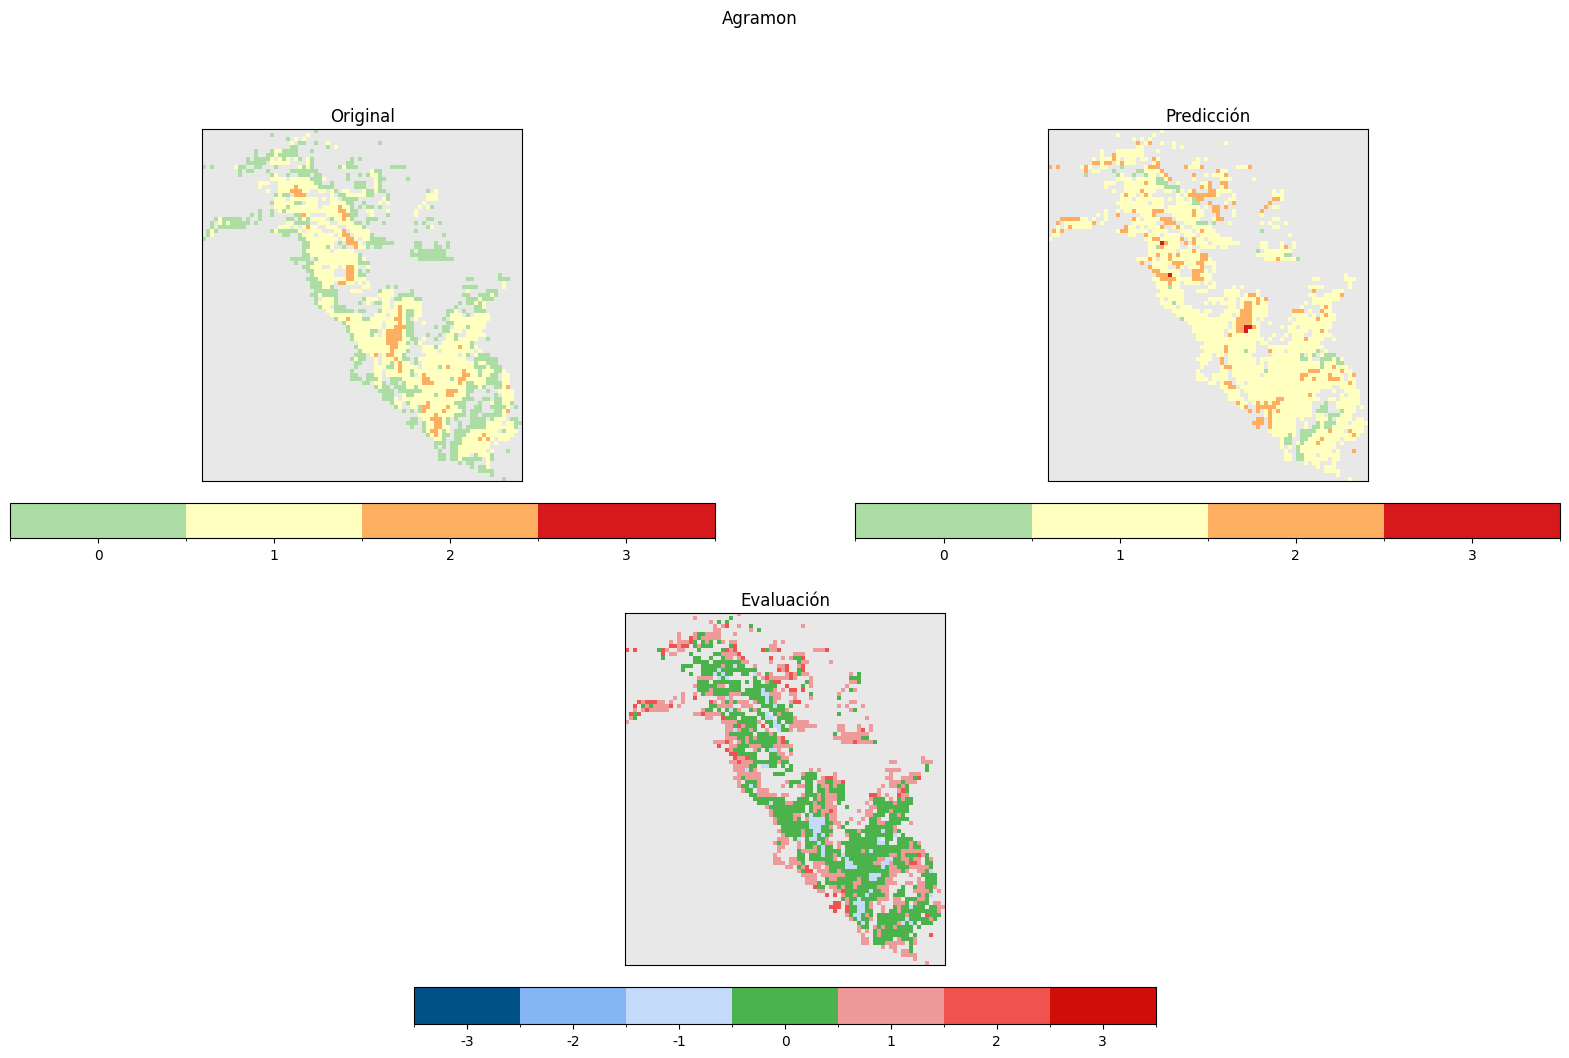

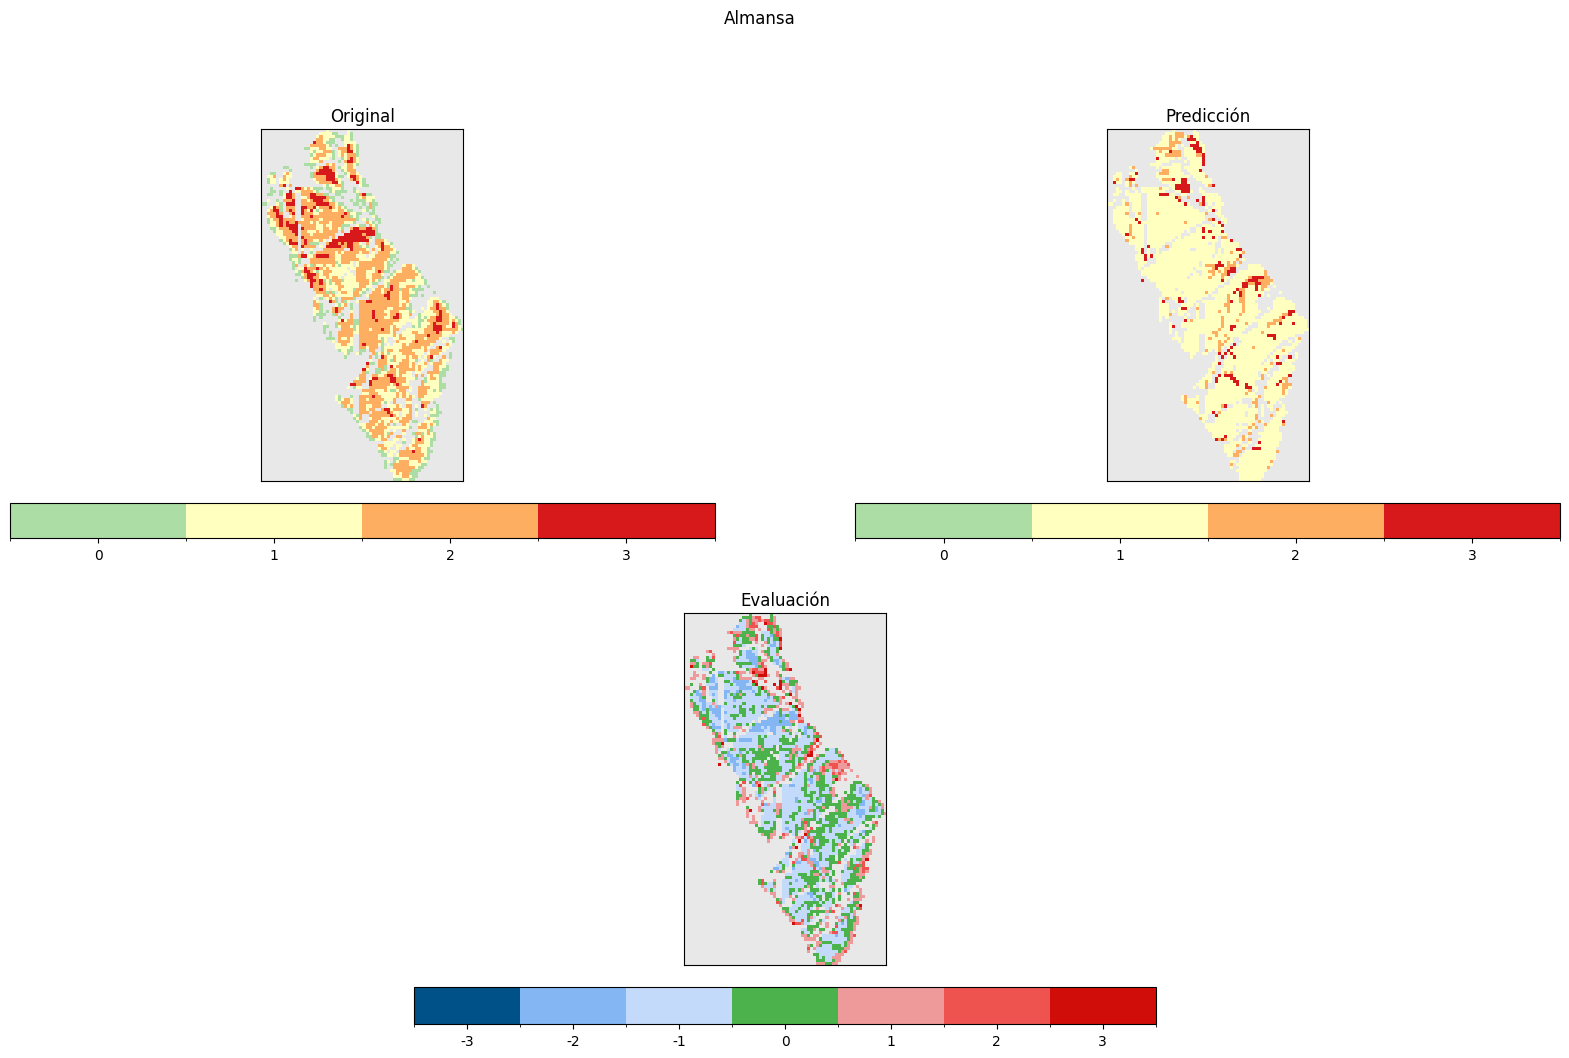

In [14]:
for fire_name in test_fire_names:
    df_fire = df_test[df_test['incendio'] == fire_name].reset_index(drop=True)

    X_fire = df_fire[variables]
    y_fire = df_fire[target_discrete]
    coords_fire = df_fire[coords_columns]

    pred = final_model['baja_alta'].predict(X_fire)
    predictions_baja_alta = pred
    pred_fire = np.zeros_like(predictions_baja_alta)

    if np.count_nonzero(predictions_baja_alta == 0) > 0:
        indexes_pred_baja = X_fire.index[predictions_baja_alta == 0]
        pred = final_model['baja_mediabaja'].predict(X_fire.loc[predictions_baja_alta == 0])


        predictions_baja_media = pred
        predictions_baja_media = np.where(predictions_baja_media == 0, 0, 1)
        pred_fire[indexes_pred_baja] = predictions_baja_media

    if np.count_nonzero(predictions_baja_alta == 1) > 0:
        indexes_pred_alta = X_fire.index[predictions_baja_alta == 1]
        pred = final_model['mediaalta_alta'].predict(X_fire.loc[predictions_baja_alta == 1])

        predictions_alta_muyalta = pred
        predictions_alta_muyalta = np.where(predictions_alta_muyalta == 0, 2, 3)
        pred_fire[indexes_pred_alta] = predictions_alta_muyalta

    matrix_fire = sm.get_severity_matrix(y_fire, coords_fire)
    matrix_pred = sm.get_severity_matrix(pred_fire, coords_fire)
    sm.show_original_prediction_evaluation_severity_matrices(matrix_fire, matrix_pred, fig_title=fire_name)

# Zona TO_CR_GU

In [15]:
fire_names = list(df[df['provincia'].isin(Zona.TO_CR_GU.value)]['incendio'].unique())
test_fire_names = ['Malagon', 'La_Iglesuela']
train_fire_names = [x for x in fire_names if x not in test_fire_names]

print(f'Train: {train_fire_names}')
print(f'Test:  {test_fire_names}')

Train: ['Bustares', 'Cogolludo', 'Almorox', 'Cadalso', 'Montesion', 'Villanueva_de_Bogas']
Test:  ['Malagon', 'La_Iglesuela']


In [16]:
df_train = df[df['incendio'].isin(train_fire_names)].reset_index(drop=True)
print(len(df_train))
df_train.head()

45044


,elevacion,erodi,slope,orientacion_sen,orientacion_cos,altura,lfcc,inflam,mcroth,anomalia,dpv,vel_media_viento,severidad_real,severidad_discreta,coord_x_etrs89,coord_y_etrs89,incendio,provincia
0,1286.896973,4,23.457001,-0.055359,0.998467,2.0,6.383800,3,3,78.232872,2.447998,4.317896,0.237689,0,496920.0,4558830.0,Bustares,Guadalajara
1,1301.120972,4,21.378000,-0.231134,0.972922,2.0,1.801800,3,3,78.218384,2.447738,4.317962,0.235222,0,496920.0,4558800.0,Bustares,Guadalajara
2,1339.094971,4,20.363001,0.578251,0.815859,1.0,0.444400,3,3,78.369110,2.450908,4.318116,0.258634,0,496620.0,4558770.0,Bustares,Guadalajara
3,1313.015991,4,28.674999,-0.287109,0.957898,4.0,28.321201,3,3,78.203880,2.447479,4.318027,0.253629,0,496920.0,4558770.0,Bustares,Guadalajara
4,1375.686035,4,13.819000,0.611061,0.791583,1.0,0.101900,3,3,78.357872,2.450803,4.318330,0.284624,1,496560.0,4558680.0,Bustares,Guadalajara


In [17]:
df_test = df[df['incendio'].isin(test_fire_names)].reset_index(drop=True)
print(len(df_test))
df_test.head()

19923


,elevacion,erodi,slope,orientacion_sen,orientacion_cos,altura,lfcc,inflam,mcroth,anomalia,dpv,vel_media_viento,severidad_real,severidad_discreta,coord_x_etrs89,coord_y_etrs89,incendio,provincia
0,834.695007,4,13.863,0.751454,0.659785,2.0,5.668000,3,1,81.601456,3.425242,3.003078,0.191698,0,407730.0,4350900.0,Malagon,Ciudad Real
1,829.068970,4,13.428,0.908389,0.418126,8.0,33.096100,3,1,81.601067,3.425281,3.003020,0.197681,0,407760.0,4350900.0,Malagon,Ciudad Real
2,850.950989,4,14.210,0.511204,0.859459,3.0,19.678999,3,1,81.605385,3.425198,3.003275,0.201897,0,407640.0,4350870.0,Malagon,Ciudad Real
3,846.922974,4,12.434,0.627528,0.778594,2.0,6.818200,3,1,81.605011,3.425238,3.003217,0.229464,0,407670.0,4350870.0,Malagon,Ciudad Real
4,842.739990,4,12.307,0.760491,0.649348,5.0,0.431000,3,1,81.604637,3.425277,3.003159,0.247409,0,407700.0,4350870.0,Malagon,Ciudad Real


## Baja - Alta

In [54]:
new_classification = {0:0, 1:0, 2:1, 3:1}

df_train_reclass = reclass(new_classification, df_train)
df_test_reclass = reclass(new_classification, df_test)

In [55]:
X_train = df_train_reclass[variables]
y_train = df_train_reclass[target_discrete]

X_test = df_test_reclass[variables]
y_test = df_test_reclass[target_discrete]

In [56]:
folds = []

for name in train_fire_names:
    fold_train_names = [x for x in train_fire_names if x != name]
    fold_test_name = [x for x in train_fire_names if x == name]

    fold_train_indices = df_train_reclass[(df_train_reclass['incendio'].isin(fold_train_names))].index
    fold_test_indices = df_train_reclass[df_train_reclass['incendio'].isin(fold_test_name)].index
    folds.append((fold_train_indices, fold_test_indices))

[print(f'Fold {i}: Train: {x.size}\tTest:{y.size}') for i, (x, y) in enumerate(folds)];

Fold 0: Train: 42079	Test:2965
Fold 1: Train: 29091	Test:15953
Fold 2: Train: 33979	Test:11065
Fold 3: Train: 38447	Test:6597
Fold 4: Train: 37270	Test:7774
Fold 5: Train: 44354	Test:690


### Grid Search

#### Logistic Regression

In [57]:
poly = PolynomialFeatures(include_bias=False)
logistic_reg = LogisticRegression(random_state=seed)
logistic_reg_pipeline = make_pipeline(preprocessing, poly, logistic_reg)

param_grid = {
    'polynomialfeatures__degree': [1, 2],
    'logisticregression__C': [0.01, 0.1, 1, 2, 5, 10],
    'logisticregression__max_iter': [100, 200]
}

logistic_reg_gs = optimize_params(logistic_reg_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 6 folds for each of 24 candidates, totalling 144 fits
Time: 50.52 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__max_iter,param_polynomialfeatures__degree,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
23,5.477468,0.403473,0.034725,0.028710,10,200,2,"{'logisticregression__C': 10, 'logisticregress...",0.328067,0.269319,0.218063,1,0.434035,0.429944,0.060300
15,7.867506,0.803585,0.069676,0.041012,2,200,2,"{'logisticregression__C': 2, 'logisticregressi...",0.310022,0.258108,0.217352,2,0.430343,0.426345,0.062283
19,7.855534,0.892481,0.067421,0.041837,5,200,2,"{'logisticregression__C': 5, 'logisticregressi...",0.304387,0.253510,0.224449,3,0.432660,0.428467,0.062005
11,7.766811,0.862665,0.061423,0.039348,1,200,2,"{'logisticregression__C': 1, 'logisticregressi...",0.268624,0.230382,0.233379,4,0.427949,0.423954,0.059045
22,0.570568,0.067407,0.023154,0.011842,10,200,1,"{'logisticregression__C': 10, 'logisticregress...",0.224211,0.173568,0.245711,5,0.275422,0.268304,0.093899
20,0.599396,0.083247,0.024015,0.005751,10,100,1,"{'logisticregression__C': 10, 'logisticregress...",0.224211,0.173568,0.245711,6,0.275422,0.268304,0.093899
18,0.607276,0.083226,0.030326,0.007688,5,200,1,"{'logisticregression__C': 5, 'logisticregressi...",0.223364,0.173187,0.245141,7,0.275466,0.268355,0.093801
16,0.621951,0.075334,0.036427,0.018803,5,100,1,"{'logisticregression__C': 5, 'logisticregressi...",0.223302,0.173158,0.245097,8,0.275465,0.268354,0.093804
14,0.821621,0.343426,0.030206,0.012932,2,200,1,"{'logisticregression__C': 2, 'logisticregressi...",0.221817,0.172442,0.244039,9,0.275465,0.268353,0.093788
12,0.617404,0.084822,0.026697,0.007663,2,100,1,"{'logisticregression__C': 2, 'logisticregressi...",0.221791,0.172377,0.243951,10,0.275472,0.268362,0.093799


c:\Users\Alejandro.Martinez\AppData\Local\miniconda3\envs\nuevoEntorno\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### KNeighbors

In [58]:
k_neighbors_class = KNeighborsClassifier()
k_neighbours_class_pipeline = make_pipeline(preprocessing, k_neighbors_class)

param_grid = {
    'kneighborsclassifier__n_neighbors': [5, 10, 20, 50, 100],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}

k_neighbors_class_gs = optimize_params(k_neighbours_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 6 folds for each of 10 candidates, totalling 60 fits
Time: 125.1 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,param_kneighborsclassifier__weights,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
0,0.050578,0.005925,2.919525,1.755149,5,uniform,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.208512,0.166156,0.135160,1,0.660902,0.658861,0.028359
1,0.043218,0.009501,2.794157,1.595406,5,distance,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.208512,0.166156,0.135160,2,1.000000,1.000000,0.000000
3,0.040237,0.009290,2.934788,1.682389,10,distance,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.194966,0.151469,0.139869,3,1.000000,1.000000,0.000000
5,0.041096,0.008145,2.918144,1.571829,20,distance,"{'kneighborsclassifier__n_neighbors': 20, 'kne...",0.185471,0.138344,0.141092,4,1.000000,1.000000,0.000000
7,0.043000,0.003753,3.148540,1.855879,50,distance,"{'kneighborsclassifier__n_neighbors': 50, 'kne...",0.178775,0.152768,0.124551,5,1.000000,1.000000,0.000000
6,0.037945,0.003211,3.100795,1.795769,50,uniform,"{'kneighborsclassifier__n_neighbors': 50, 'kne...",0.172485,0.148671,0.122325,6,0.482093,0.477629,0.058721
4,0.036476,0.008207,2.849734,1.612831,20,uniform,"{'kneighborsclassifier__n_neighbors': 20, 'kne...",0.171309,0.125395,0.131892,7,0.518858,0.514748,0.054106
2,0.039208,0.002432,2.699676,1.511666,10,uniform,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.169617,0.124934,0.125778,8,0.552802,0.549399,0.046818
9,0.041572,0.005625,3.478439,2.006017,100,distance,"{'kneighborsclassifier__n_neighbors': 100, 'kn...",0.168194,0.140960,0.118577,9,1.000000,1.000000,0.000000
8,0.040245,0.009216,3.480617,1.971207,100,uniform,"{'kneighborsclassifier__n_neighbors': 100, 'kn...",0.163046,0.135652,0.116903,10,0.457946,0.452750,0.068004


#### Decision Tree

In [59]:
decision_tree_class = DecisionTreeClassifier(random_state=seed)
decision_tree_class_pipeline = make_pipeline(preprocessing, decision_tree_class)

param_grid = {
    'decisiontreeclassifier__max_depth': [3, 5, 7, 10, None],
    'decisiontreeclassifier__min_samples_split': [2, 50, 200],
    'decisiontreeclassifier__criterion': ['entropy', 'gini'],
    'decisiontreeclassifier__ccp_alpha': [0, 0.0001, 0.001, 0.01, 0.1]
}

decision_tree_class_gs = optimize_params(decision_tree_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 6 folds for each of 150 candidates, totalling 900 fits
Time: 100.4 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__ccp_alpha,param_decisiontreeclassifier__criterion,param_decisiontreeclassifier__max_depth,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
12,2.089677,0.333167,0.011172,0.005989,0,entropy,None,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.209641,0.191772,0.179814,1,1.000000,1.000000,0.000000
42,2.100108,0.347204,0.015067,0.006691,0.0001,entropy,None,"{'decisiontreeclassifier__ccp_alpha': 0.0001, ...",0.206224,0.183229,0.166381,2,0.939169,0.942227,0.023087
21,0.912015,0.114310,0.014795,0.007239,0,gini,7,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.199325,0.185757,0.200137,3,0.554861,0.552067,0.028727
27,1.794849,0.258438,0.013296,0.004729,0,gini,None,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.198891,0.231337,0.155278,4,1.000000,1.000000,0.000000
28,1.614005,0.266050,0.010261,0.006480,0,gini,None,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.190827,0.216659,0.161021,5,0.767653,0.766394,0.017396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.799221,0.108525,0.016107,0.003225,0.1,entropy,5,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.000000,0.000000,0.000000,146,0.000000,0.000000,0.000000
124,0.788608,0.110631,0.015412,0.005534,0.1,entropy,5,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.000000,0.000000,0.000000,147,0.000000,0.000000,0.000000
125,0.809200,0.120386,0.013295,0.003947,0.1,entropy,5,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.000000,0.000000,0.000000,148,0.000000,0.000000,0.000000
126,1.054196,0.154301,0.014202,0.005385,0.1,entropy,7,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.000000,0.000000,0.000000,149,0.000000,0.000000,0.000000


#### Random Forest

In [60]:
random_forest_class = RandomForestClassifier(random_state=seed)
random_forest_class_pipeline = make_pipeline(preprocessing, random_forest_class)

param_grid = {
    'randomforestclassifier__n_estimators': [10, 25, 50],
    'randomforestclassifier__max_depth': [3, 5, 7, None],
    'randomforestclassifier__criterion': ['entropy', 'gini'],
}

random_forest_class_gs = optimize_params(random_forest_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 6 folds for each of 24 candidates, totalling 144 fits
Time: 77.34 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__criterion,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
21,3.171900,0.498045,0.024750,0.012124,gini,None,10,"{'randomforestclassifier__criterion': 'gini', ...",0.004173,0.014632,0.020372,1,0.979732,0.979472,0.002980
9,3.698221,0.610301,0.022213,0.010605,entropy,None,10,{'randomforestclassifier__criterion': 'entropy...,0.003520,0.003849,0.008313,2,0.980207,0.979952,0.002563
22,7.607409,1.179570,0.035084,0.017852,gini,None,25,"{'randomforestclassifier__criterion': 'gini', ...",0.002921,0.004387,0.005696,3,0.997644,0.997645,0.000279
15,1.140020,0.155199,0.022280,0.011285,gini,5,10,"{'randomforestclassifier__criterion': 'gini', ...",0.000561,0.000638,0.001427,4,0.317270,0.306951,0.123796
10,8.922751,1.388711,0.032179,0.020007,entropy,None,25,{'randomforestclassifier__criterion': 'entropy...,0.000375,0.000427,0.000954,5,0.997637,0.997626,0.000252
11,17.931243,2.823568,0.061179,0.030759,entropy,None,50,{'randomforestclassifier__criterion': 'entropy...,0.000353,0.000166,0.000371,6,0.999506,0.999490,0.000208
23,12.437154,1.223580,0.040189,0.023316,gini,None,50,"{'randomforestclassifier__criterion': 'gini', ...",0.000306,0.000269,0.000470,7,0.999546,0.999522,0.000208
13,1.752847,0.274002,0.025833,0.009991,gini,3,25,"{'randomforestclassifier__criterion': 'gini', ...",0.000134,0.000338,0.000756,8,0.273091,0.262658,0.119916
14,3.317367,0.499505,0.036758,0.017910,gini,3,50,"{'randomforestclassifier__criterion': 'gini', ...",0.000000,0.000000,0.000000,9,0.274492,0.264153,0.120903
20,7.018546,1.066555,0.045140,0.025577,gini,7,50,"{'randomforestclassifier__criterion': 'gini', ...",0.000000,0.000000,0.000000,10,0.385494,0.379306,0.087973


#### XGBoost

In [61]:
xgb_class = XGBClassifier(random_state=seed)
xgb_class_pipeline = make_pipeline(preprocessing, xgb_class)

param_grid = {
    'xgbclassifier__n_estimators': [10, 25, 50, 100],
    'xgbclassifier__max_depth': [3, 5, 7, 10, None],
    'xgbclassifier__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
}

xgb_class_gs = optimize_params(xgb_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 6 folds for each of 120 candidates, totalling 720 fits
Time: 74.82 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__learning_rate,param_xgbclassifier__max_depth,param_xgbclassifier__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
112,0.619826,0.056978,0.025741,0.006026,0.2,10,10,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.021082,0.042758,0.079593,1,0.743651,0.743411,0.019498
55,4.528680,0.296047,0.068455,0.037767,0.01,10,100,"{'xgbclassifier__learning_rate': 0.01, 'xgbcla...",0.020926,0.050547,0.111124,2,0.624439,0.622239,0.045611
108,0.343019,0.044042,0.022404,0.010285,0.2,7,10,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.012481,0.029190,0.063804,3,0.578310,0.576625,0.037305
73,1.329848,0.091318,0.034103,0.017067,0.05,10,25,"{'xgbclassifier__learning_rate': 0.05, 'xgbcla...",0.012210,0.027501,0.058597,4,0.681105,0.680112,0.031764
92,0.675671,0.052347,0.026636,0.011221,0.1,10,10,"{'xgbclassifier__learning_rate': 0.1, 'xgbclas...",0.011701,0.026705,0.057838,5,0.641850,0.639759,0.038148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,2.503565,0.269800,0.047105,0.023195,0.005,10,50,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,116,0.000000,0.000000,0.000000
33,1.364597,0.136188,0.036662,0.015801,0.005,10,25,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,117,0.000000,0.000000,0.000000
32,0.686232,0.081455,0.027669,0.009226,0.005,10,10,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,118,0.000000,0.000000,0.000000
31,1.642012,0.121735,0.052642,0.028866,0.005,7,100,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,119,0.121341,0.118194,0.043511


#### SGD

In [62]:
sgd_class = SGDClassifier(random_state=seed)
sgd_class_pipeline = make_pipeline(preprocessing, sgd_class)

param_grid = {
    'sgdclassifier__alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.8],
    'sgdclassifier__max_iter': [50, 100, 500, 1000],
    'sgdclassifier__loss': ['log_loss', 'hinge', 'modified_huber'],
    'sgdclassifier__class_weight': ['balanced', None, {0:1, 1:2}]
}

sgd_class_gs = optimize_params(sgd_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 6 folds for each of 252 candidates, totalling 1512 fits
Time: 45.14 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdclassifier__alpha,param_sgdclassifier__class_weight,param_sgdclassifier__loss,param_sgdclassifier__max_iter,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
216,0.152726,0.023964,0.017435,0.007774,0.8,balanced,log_loss,50,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.350674,0.268210,0.190779,1,0.457606,0.457453,0.021084
219,0.150715,0.021639,0.019129,0.004361,0.8,balanced,log_loss,1000,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.350674,0.268210,0.190779,2,0.457606,0.457453,0.021084
218,0.157201,0.028433,0.015185,0.006900,0.8,balanced,log_loss,500,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.350674,0.268210,0.190779,3,0.457606,0.457453,0.021084
217,0.157612,0.023902,0.015475,0.004819,0.8,balanced,log_loss,100,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.350674,0.268210,0.190779,4,0.457606,0.457453,0.021084
0,0.372286,0.044180,0.019853,0.008268,0.0001,balanced,log_loss,50,"{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.331102,0.276159,0.205440,5,0.481231,0.479786,0.026106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,0.122780,0.017267,0.016116,0.006597,0.5,None,hinge,100,"{'sgdclassifier__alpha': 0.5, 'sgdclassifier__...",0.000000,0.000000,0.000000,248,0.000000,0.000000,0.000000
199,0.126336,0.015238,0.018314,0.005445,0.5,None,hinge,1000,"{'sgdclassifier__alpha': 0.5, 'sgdclassifier__...",0.000000,0.000000,0.000000,249,0.000000,0.000000,0.000000
55,0.209552,0.026349,0.019240,0.006696,0.001,None,hinge,1000,"{'sgdclassifier__alpha': 0.001, 'sgdclassifier...",0.000000,0.000000,0.000000,250,0.000000,0.000000,0.000000
54,0.198323,0.019910,0.016726,0.008971,0.001,None,hinge,500,"{'sgdclassifier__alpha': 0.001, 'sgdclassifier...",0.000000,0.000000,0.000000,251,0.000000,0.000000,0.000000


### Evaluación

In [63]:
models_dict = {
    'Regresion logistica': logistic_reg_gs,
    'KNeighbors' : k_neighbors_class_gs,
    'Arbol de decision': decision_tree_class_gs,
    'Random Forest': random_forest_class_gs,
    'XGBoost': xgb_class_gs,
    'SGD': sgd_class_gs
}


df_results = pd.DataFrame({
    'Modelo': models_dict.keys(),
    'Mejor puntuacion': [gs.best_score_ for gs in models_dict.values()]
})
df_results = df_results.sort_values(by='Mejor puntuacion', ascending=False)
df_results

,Modelo,Mejor puntuacion
5,SGD,0.350674
0,Regresion logistica,0.328067
2,Arbol de decision,0.209641
1,KNeighbors,0.208512
4,XGBoost,0.021082
3,Random Forest,0.004173


In [64]:
best_model = models_dict[df_results.loc[df_results.index[0], 'Modelo']].best_estimator_
model_path = os.path.join('models', 'experiment_4', 'TO_CR_GU', 'model_baja_alta.joblib')
dump(best_model, model_path)

['models\\model_4\\to_cr_gu\\model_baja_alta.joblib']

In [65]:
model_path = os.path.join('models', 'experiment_4', 'TO_CR_GU', 'model_baja_alta.joblib')
model = load(model_path)
pred = model.predict(X_test)

print(f"""Métricas predicción del test
F1:        {f1_score(y_test, pred)}
Recall:    {recall_score(y_test, pred)}
Precision: {precision_score(y_test, pred)}
Accuracy:  {accuracy_score(y_test, pred)}""")

Métricas predicción del test
F1:        0.4301196774359237
Recall:    0.3691588785046729
Precision: 0.5151962593823058
Accuracy:  0.4431059579380615


## Baja - Media baja

In [66]:
new_classification = {0:0, 1:1}

df_train_reclass = reclass(new_classification, df_train)
df_test_reclass = reclass(new_classification, df_train)

In [67]:
X_train = df_train_reclass[variables]
y_train = df_train_reclass[target_discrete]

X_test = df_test_reclass[variables]
y_test = df_test_reclass[target_discrete]

In [68]:
folds = []

for name in train_fire_names:
    fold_train_names = [x for x in train_fire_names if x != name]
    fold_test_name = [x for x in train_fire_names if x == name]

    fold_train_indices = df_train_reclass[(df_train_reclass['incendio'].isin(fold_train_names))].index
    fold_test_indices = df_train_reclass[df_train_reclass['incendio'].isin(fold_test_name)].index
    folds.append((fold_train_indices, fold_test_indices))

[print(f'Fold {i}: Train: {x.size}\tTest:{y.size}') for i, (x, y) in enumerate(folds)];

Fold 0: Train: 29816	Test:1981
Fold 1: Train: 21861	Test:9936
Fold 2: Train: 24104	Test:7693
Fold 3: Train: 26757	Test:5040
Fold 4: Train: 25329	Test:6468
Fold 5: Train: 31118	Test:679


### Grid Search

#### Logistic Regression

In [69]:
poly = PolynomialFeatures(include_bias=False)
logistic_reg = LogisticRegression(random_state=seed)
logistic_reg_pipeline = make_pipeline(preprocessing, poly, logistic_reg)

param_grid = {
    'polynomialfeatures__degree': [1, 2],
    'logisticregression__C': [0.01, 0.1, 1, 2, 5, 10],
    'logisticregression__max_iter': [100, 200]
}

logistic_reg_gs = optimize_params(logistic_reg_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 6 folds for each of 24 candidates, totalling 144 fits
Time: 35.72 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__max_iter,param_polynomialfeatures__degree,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
1,3.026008,0.314447,0.053672,0.022974,0.01,100,2,"{'logisticregression__C': 0.01, 'logisticregre...",0.480431,0.450903,0.323727,1,0.742848,0.743425,0.018818
3,4.340935,0.384898,0.051452,0.023202,0.01,200,2,"{'logisticregression__C': 0.01, 'logisticregre...",0.479706,0.453200,0.319535,2,0.742678,0.743273,0.018711
0,0.211677,0.043713,0.017601,0.003493,0.01,100,1,"{'logisticregression__C': 0.01, 'logisticregre...",0.387618,0.386613,0.284936,3,0.714579,0.715370,0.022997
2,0.260102,0.042648,0.022684,0.006969,0.01,200,1,"{'logisticregression__C': 0.01, 'logisticregre...",0.387618,0.386613,0.284936,4,0.714579,0.715370,0.022997
22,0.339276,0.092883,0.022816,0.011926,10,200,1,"{'logisticregression__C': 10, 'logisticregress...",0.375032,0.347372,0.332697,5,0.712902,0.713697,0.025149
20,0.358246,0.123557,0.023455,0.003712,10,100,1,"{'logisticregression__C': 10, 'logisticregress...",0.375032,0.347372,0.332697,6,0.712902,0.713697,0.025149
14,0.382517,0.139918,0.023334,0.008015,2,200,1,"{'logisticregression__C': 2, 'logisticregressi...",0.374746,0.346656,0.333305,7,0.712905,0.713712,0.025096
12,0.368383,0.127230,0.022800,0.006664,2,100,1,"{'logisticregression__C': 2, 'logisticregressi...",0.374746,0.346656,0.333305,8,0.712906,0.713713,0.025098
16,0.348225,0.098755,0.021748,0.008080,5,100,1,"{'logisticregression__C': 5, 'logisticregressi...",0.374744,0.346651,0.333310,9,0.712929,0.713730,0.025174
18,0.327869,0.088989,0.022906,0.006724,5,200,1,"{'logisticregression__C': 5, 'logisticregressi...",0.374744,0.346651,0.333310,10,0.712929,0.713730,0.025174


c:\Users\Alejandro.Martinez\AppData\Local\miniconda3\envs\nuevoEntorno\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### KNeighbors

In [70]:
k_neighbors_class = KNeighborsClassifier()
k_neighbours_class_pipeline = make_pipeline(preprocessing, k_neighbors_class)

param_grid = {
    'kneighborsclassifier__n_neighbors': [5, 10, 20, 50, 100],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}

k_neighbors_class_gs = optimize_params(k_neighbours_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 6 folds for each of 10 candidates, totalling 60 fits
Time: 66.27 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,param_kneighborsclassifier__weights,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
9,0.036361,0.003293,2.113520,1.147870,100,distance,"{'kneighborsclassifier__n_neighbors': 100, 'kn...",0.576050,0.573447,0.108429,1,1.000000,1.000000,0.000000
7,0.033969,0.004955,1.738308,0.911750,50,distance,"{'kneighborsclassifier__n_neighbors': 50, 'kne...",0.573137,0.561617,0.096263,2,1.000000,1.000000,0.000000
8,0.032525,0.006608,2.023561,1.070854,100,uniform,"{'kneighborsclassifier__n_neighbors': 100, 'kn...",0.570402,0.569010,0.112740,3,0.750195,0.750469,0.016627
5,0.028093,0.005311,1.490033,0.756451,20,distance,"{'kneighborsclassifier__n_neighbors': 20, 'kne...",0.564404,0.548180,0.084426,4,1.000000,1.000000,0.000000
6,0.030545,0.004865,1.601805,0.810624,50,uniform,"{'kneighborsclassifier__n_neighbors': 50, 'kne...",0.561725,0.550016,0.103627,5,0.754201,0.754440,0.016042
3,0.030062,0.003148,1.481652,0.741855,10,distance,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.550411,0.532522,0.075176,6,1.000000,1.000000,0.000000
4,0.030956,0.002534,1.470849,0.757384,20,uniform,"{'kneighborsclassifier__n_neighbors': 20, 'kne...",0.542220,0.524205,0.096507,7,0.763603,0.763844,0.015506
0,0.028763,0.006480,1.468466,0.812599,5,uniform,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.541723,0.524965,0.066807,8,0.806647,0.806782,0.010303
1,0.029025,0.006769,1.434684,0.829881,5,distance,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.541723,0.524965,0.066807,9,1.000000,1.000000,0.000000
2,0.032831,0.004321,1.432568,0.775834,10,uniform,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.507485,0.489460,0.090242,10,0.769547,0.769655,0.013647


#### Decision Tree

In [71]:
decision_tree_class = DecisionTreeClassifier(random_state=seed)
decision_tree_class_pipeline = make_pipeline(preprocessing, decision_tree_class)

param_grid = {
    'decisiontreeclassifier__max_depth': [3, 5, 7, 10, None],
    'decisiontreeclassifier__min_samples_split': [2, 50, 200],
    'decisiontreeclassifier__criterion': ['entropy', 'gini'],
    'decisiontreeclassifier__ccp_alpha': [0, 0.0001, 0.001, 0.01, 0.1]
}

decision_tree_class_gs = optimize_params(decision_tree_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 6 folds for each of 150 candidates, totalling 900 fits
Time: 74.15 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__ccp_alpha,param_decisiontreeclassifier__criterion,param_decisiontreeclassifier__max_depth,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
149,0.921354,0.111465,0.008386,0.002556,0.1,gini,None,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.743240,0.738487,0.062646,1,0.745740,0.746037,0.015123
115,0.852438,0.109921,0.009630,0.004817,0.01,gini,10,"{'decisiontreeclassifier__ccp_alpha': 0.01, 'd...",0.743240,0.738487,0.062646,2,0.745740,0.746037,0.015123
125,0.560944,0.076352,0.011825,0.001863,0.1,entropy,5,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.743240,0.738487,0.062646,3,0.745740,0.746037,0.015123
124,0.572912,0.069958,0.012900,0.003777,0.1,entropy,5,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.743240,0.738487,0.062646,4,0.745740,0.746037,0.015123
123,0.576260,0.071428,0.012063,0.002605,0.1,entropy,5,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.743240,0.738487,0.062646,5,0.745740,0.746037,0.015123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,1.692539,0.251594,0.012386,0.006143,0,entropy,None,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.333847,0.320870,0.196445,146,1.000000,1.000000,0.000000
42,1.693329,0.227995,0.012422,0.002244,0.0001,entropy,None,"{'decisiontreeclassifier__ccp_alpha': 0.0001, ...",0.329611,0.311085,0.204682,147,0.987825,0.988613,0.006825
57,1.431747,0.176352,0.010643,0.003571,0.0001,gini,None,"{'decisiontreeclassifier__ccp_alpha': 0.0001, ...",0.315588,0.257296,0.158078,148,0.890990,0.892780,0.015456
13,1.463434,0.202717,0.012122,0.004065,0,entropy,None,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.272299,0.241860,0.194869,149,0.849787,0.849794,0.006669


#### Random Forest

In [72]:
random_forest_class = RandomForestClassifier(random_state=seed)
random_forest_class_pipeline = make_pipeline(preprocessing, random_forest_class)

param_grid = {
    'randomforestclassifier__n_estimators': [10, 25, 50],
    'randomforestclassifier__max_depth': [3, 5, 7, None],
    'randomforestclassifier__criterion': ['entropy', 'gini'],
}

random_forest_class_gs = optimize_params(random_forest_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 6 folds for each of 24 candidates, totalling 144 fits
Time: 56.27 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__criterion,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
12,0.511360,0.077231,0.014243,0.004823,gini,3,10,"{'randomforestclassifier__criterion': 'gini', ...",0.596624,0.636858,0.178788,1,0.747545,0.747447,0.018910
0,0.551261,0.110491,0.017035,0.005675,entropy,3,10,{'randomforestclassifier__criterion': 'entropy...,0.588691,0.631393,0.190595,2,0.748029,0.747981,0.018247
13,1.225585,0.195835,0.021109,0.008853,gini,3,25,"{'randomforestclassifier__criterion': 'gini', ...",0.545696,0.600574,0.259948,3,0.749989,0.750243,0.016825
1,1.478304,0.220728,0.025472,0.009054,entropy,3,25,{'randomforestclassifier__criterion': 'entropy...,0.544828,0.600074,0.261648,4,0.749942,0.750303,0.016286
14,2.344600,0.332377,0.031492,0.014294,gini,3,50,"{'randomforestclassifier__criterion': 'gini', ...",0.540530,0.597040,0.268752,5,0.750736,0.751003,0.016040
2,2.803078,0.346155,0.033593,0.013779,entropy,3,50,{'randomforestclassifier__criterion': 'entropy...,0.539586,0.595842,0.269301,6,0.750926,0.751207,0.015542
15,0.796835,0.101844,0.018958,0.006489,gini,5,10,"{'randomforestclassifier__criterion': 'gini', ...",0.509629,0.534366,0.191986,7,0.765557,0.765729,0.014806
18,1.026513,0.135729,0.021546,0.007837,gini,7,10,"{'randomforestclassifier__criterion': 'gini', ...",0.488182,0.513212,0.232767,8,0.787179,0.787799,0.012069
17,3.705121,0.443969,0.035728,0.017152,gini,5,50,"{'randomforestclassifier__criterion': 'gini', ...",0.486136,0.530161,0.253302,9,0.771936,0.772245,0.012009
5,4.375771,0.502989,0.033385,0.015299,entropy,5,50,{'randomforestclassifier__criterion': 'entropy...,0.483385,0.519633,0.246014,10,0.773334,0.773675,0.012441


#### XGBoost

In [73]:
xgb_class = XGBClassifier(random_state=seed)
xgb_class_pipeline = make_pipeline(preprocessing, xgb_class)

param_grid = {
    'xgbclassifier__n_estimators': [10, 25, 50, 100],
    'xgbclassifier__max_depth': [3, 5, 7, 10, None],
    'xgbclassifier__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
}

xgb_class_gs = optimize_params(xgb_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 6 folds for each of 120 candidates, totalling 720 fits
Time: 61.39 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__learning_rate,param_xgbclassifier__max_depth,param_xgbclassifier__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
0,0.138880,0.023195,0.018550,0.004111,0.001,3,10,"{'xgbclassifier__learning_rate': 0.001, 'xgbcl...",0.743240,0.738487,0.062646,1,0.745740,0.746037,0.015123
32,0.576339,0.033855,0.022289,0.008044,0.005,10,10,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.743240,0.738487,0.062646,2,0.745740,0.746037,0.015123
20,0.200245,0.011330,0.019616,0.005352,0.005,3,10,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.743240,0.738487,0.062646,3,0.745740,0.746037,0.015123
21,0.260447,0.027251,0.024095,0.005702,0.005,3,25,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.743240,0.738487,0.062646,4,0.745740,0.746037,0.015123
24,0.219524,0.022605,0.020322,0.007923,0.005,5,10,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.743240,0.738487,0.062646,5,0.745740,0.746037,0.015123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,0.732453,0.071440,0.026545,0.016658,0.2,None,100,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.207685,0.136909,0.173798,116,0.864801,0.865457,0.008081
99,0.814187,0.052075,0.036318,0.016340,0.1,None,100,"{'xgbclassifier__learning_rate': 0.1, 'xgbclas...",0.203939,0.135792,0.164289,117,0.834763,0.835394,0.010901
107,0.645105,0.041691,0.032607,0.013493,0.2,5,100,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.190460,0.130630,0.157186,118,0.835033,0.835661,0.011710
87,0.647642,0.072187,0.031501,0.016318,0.1,5,100,"{'xgbclassifier__learning_rate': 0.1, 'xgbclas...",0.173620,0.107826,0.152360,119,0.812409,0.812973,0.011924


#### SGD

In [74]:
sgd_class = SGDClassifier(random_state=seed)
sgd_class_pipeline = make_pipeline(preprocessing, sgd_class)

param_grid = {
    'sgdclassifier__alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.8],
    'sgdclassifier__max_iter': [50, 100, 500, 1000],
    'sgdclassifier__loss': ['log_loss', 'hinge', 'modified_huber'],
    'sgdclassifier__class_weight': ['balanced', None, {0:1, 1:2}]
}

sgd_class_gs = optimize_params(sgd_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 6 folds for each of 252 candidates, totalling 1512 fits
Time: 34.97 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdclassifier__alpha,param_sgdclassifier__class_weight,param_sgdclassifier__loss,param_sgdclassifier__max_iter,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
126,0.088900,0.008329,0.014133,0.004206,0.1,None,hinge,500,"{'sgdclassifier__alpha': 0.1, 'sgdclassifier__...",0.74324,0.738487,0.062646,1,0.745740,0.746037,0.015123
136,0.088368,0.008735,0.015536,0.004495,0.1,"{0: 1, 1: 2}",hinge,50,"{'sgdclassifier__alpha': 0.1, 'sgdclassifier__...",0.74324,0.738487,0.062646,2,0.745740,0.746037,0.015123
172,0.081002,0.010139,0.017067,0.003782,0.2,"{0: 1, 1: 2}",hinge,50,"{'sgdclassifier__alpha': 0.2, 'sgdclassifier__...",0.74324,0.738487,0.062646,3,0.745740,0.746037,0.015123
171,0.104408,0.012939,0.016100,0.003512,0.2,"{0: 1, 1: 2}",log_loss,1000,"{'sgdclassifier__alpha': 0.2, 'sgdclassifier__...",0.74324,0.738487,0.062646,4,0.745736,0.746031,0.015116
170,0.098826,0.010327,0.013827,0.004548,0.2,"{0: 1, 1: 2}",log_loss,500,"{'sgdclassifier__alpha': 0.2, 'sgdclassifier__...",0.74324,0.738487,0.062646,5,0.745736,0.746031,0.015116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,0.096718,0.021776,0.016153,0.004248,0.8,balanced,hinge,500,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.28824,0.238229,0.318708,248,0.371389,0.373835,0.254182
76,0.090654,0.005615,0.014383,0.006302,0.01,balanced,hinge,50,"{'sgdclassifier__alpha': 0.01, 'sgdclassifier_...",0.15414,0.220045,0.297297,249,0.534063,0.536462,0.051740
77,0.099882,0.015268,0.017613,0.003994,0.01,balanced,hinge,100,"{'sgdclassifier__alpha': 0.01, 'sgdclassifier_...",0.15414,0.220045,0.297297,250,0.534063,0.536462,0.051740
78,0.109196,0.008403,0.018167,0.005077,0.01,balanced,hinge,500,"{'sgdclassifier__alpha': 0.01, 'sgdclassifier_...",0.15414,0.220045,0.297297,251,0.534063,0.536462,0.051740


### Evaluación

In [75]:
models_dict = {
    'Regresion logistica': logistic_reg_gs,
    'KNeighbors' : k_neighbors_class_gs,
    'Arbol de decision': decision_tree_class_gs,
    'Random Forest': random_forest_class_gs,
    'XGBoost': xgb_class_gs,
    'SGD': sgd_class_gs
}


df_results = pd.DataFrame({
    'Modelo': models_dict.keys(),
    'Mejor puntuacion': [gs.best_score_ for gs in models_dict.values()]
})
df_results = df_results.sort_values(by='Mejor puntuacion', ascending=False)
df_results

,Modelo,Mejor puntuacion
2,Arbol de decision,0.743240
4,XGBoost,0.743240
5,SGD,0.743240
3,Random Forest,0.596624
1,KNeighbors,0.576050
0,Regresion logistica,0.480431


In [76]:
best_model = models_dict[df_results.loc[df_results.index[0], 'Modelo']].best_estimator_
model_path = os.path.join('models', 'experiment_4', 'TO_CR_GU', 'model_baja_mediabaja.joblib')
dump(best_model, model_path)

['models\\model_4\\to_cr_gu\\model_baja_mediabaja.joblib']

In [77]:
model_path = os.path.join('models', 'experiment_4', 'TO_CR_GU', 'model_baja_mediabaja.joblib')
model = load(model_path)
pred = model.predict(X_test)

print(f"""Métricas predicción del test
F1:        {f1_score(y_test, pred)}
Recall:    {recall_score(y_test, pred)}
Precision: {precision_score(y_test, pred)}
Accuracy:  {accuracy_score(y_test, pred)}""")

Métricas predicción del test
F1:        0.7459030941253031
Recall:    1.0
Precision: 0.5947730918011133
Accuracy:  0.5947730918011133


## Media alta - Alta

In [78]:
new_classification = {2:0, 3:1}

df_train_reclass = reclass(new_classification, df_train)
df_test_reclass = reclass(new_classification, df_train)

In [79]:
X_train = df_train_reclass[variables]
y_train = df_train_reclass[target_discrete]

X_test = df_test_reclass[variables]
y_test = df_test_reclass[target_discrete]

In [80]:
folds = []

for name in train_fire_names:
    fold_train_names = [x for x in train_fire_names if x != name]
    fold_test_name = [x for x in train_fire_names if x == name]

    fold_train_indices = df_train_reclass[(df_train_reclass['incendio'].isin(fold_train_names))].index
    fold_test_indices = df_train_reclass[df_train_reclass['incendio'].isin(fold_test_name)].index
    folds.append((fold_train_indices, fold_test_indices))

[print(f'Fold {i}: Train: {x.size}\tTest:{y.size}') for i, (x, y) in enumerate(folds)];

Fold 0: Train: 12263	Test:984
Fold 1: Train: 7230	Test:6017
Fold 2: Train: 9875	Test:3372
Fold 3: Train: 11690	Test:1557
Fold 4: Train: 11941	Test:1306
Fold 5: Train: 13236	Test:11


### Grid Search

#### Logistic Regression

In [81]:
poly = PolynomialFeatures(include_bias=False)
logistic_reg = LogisticRegression(random_state=seed)
logistic_reg_pipeline = make_pipeline(preprocessing, poly, logistic_reg)

param_grid = {
    'polynomialfeatures__degree': [1, 2],
    'logisticregression__C': [0.01, 0.1, 1, 2, 5, 10],
    'logisticregression__max_iter': [100, 200]
}

logistic_reg_gs = optimize_params(logistic_reg_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 6 folds for each of 24 candidates, totalling 144 fits
Time: 15.18 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__max_iter,param_polynomialfeatures__degree,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
9,1.208123,0.192957,0.025983,0.016301,1,100,2,"{'logisticregression__C': 1, 'logisticregressi...",0.042577,0.048052,0.054402,1,0.560342,0.527820,0.214074
13,1.190298,0.177671,0.027622,0.016705,2,100,2,"{'logisticregression__C': 2, 'logisticregressi...",0.040775,0.047815,0.053804,2,0.562630,0.530401,0.211816
23,1.590740,0.204316,0.019738,0.010970,10,200,2,"{'logisticregression__C': 10, 'logisticregress...",0.040203,0.052930,0.070116,3,0.567631,0.538485,0.191817
19,2.372503,0.342362,0.024916,0.012342,5,200,2,"{'logisticregression__C': 5, 'logisticregressi...",0.039328,0.051888,0.068352,4,0.566640,0.536380,0.199254
11,2.265306,0.381029,0.026940,0.014971,1,200,2,"{'logisticregression__C': 1, 'logisticregressi...",0.038897,0.046678,0.058418,5,0.563921,0.532157,0.209042
15,2.337848,0.365152,0.026418,0.016849,2,200,2,"{'logisticregression__C': 2, 'logisticregressi...",0.038752,0.049237,0.062238,6,0.566130,0.534941,0.205116
21,1.233559,0.138596,0.025243,0.018502,10,100,2,"{'logisticregression__C': 10, 'logisticregress...",0.038650,0.046521,0.053295,7,0.564751,0.532881,0.209401
17,1.173817,0.153944,0.027793,0.017153,5,100,2,"{'logisticregression__C': 5, 'logisticregressi...",0.038123,0.045809,0.052128,8,0.563966,0.532169,0.209064
7,2.370483,0.370918,0.027790,0.012427,0.1,200,2,"{'logisticregression__C': 0.1, 'logisticregres...",0.022891,0.031749,0.052393,9,0.551841,0.517756,0.224216
0,0.059088,0.019944,0.013306,0.002398,0.01,100,1,"{'logisticregression__C': 0.01, 'logisticregre...",0.009700,0.021764,0.048666,10,0.493819,0.462362,0.207012


c:\Users\Alejandro.Martinez\AppData\Local\miniconda3\envs\nuevoEntorno\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### KNeighbors

In [82]:
k_neighbors_class = KNeighborsClassifier()
k_neighbours_class_pipeline = make_pipeline(preprocessing, k_neighbors_class)

param_grid = {
    'kneighborsclassifier__n_neighbors': [5, 10, 20, 50, 100],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}

k_neighbors_class_gs = optimize_params(k_neighbours_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 6 folds for each of 10 candidates, totalling 60 fits
Time: 12.97 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,param_kneighborsclassifier__weights,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
0,0.016136,0.003739,0.248561,0.174254,5,uniform,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.161107,0.073855,0.118176,1,0.673177,0.655004,0.121582
1,0.015358,0.004148,0.233823,0.115770,5,distance,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.161107,0.073855,0.118176,2,1.000000,1.000000,0.000000
3,0.014950,0.003938,0.240015,0.170373,10,distance,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.150625,0.069280,0.110197,3,1.000000,1.000000,0.000000
2,0.018924,0.004438,0.255519,0.151128,10,uniform,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.132451,0.059179,0.096561,4,0.589131,0.561124,0.185797
5,0.018203,0.002604,0.277215,0.178841,20,distance,"{'kneighborsclassifier__n_neighbors': 20, 'kne...",0.086996,0.049641,0.059517,5,1.000000,1.000000,0.000000
4,0.019429,0.005746,0.271133,0.180640,20,uniform,"{'kneighborsclassifier__n_neighbors': 20, 'kne...",0.034988,0.028952,0.030922,6,0.560888,0.526487,0.226257
8,0.017404,0.002973,0.366196,0.242812,100,uniform,"{'kneighborsclassifier__n_neighbors': 100, 'kn...",0.022102,0.031352,0.046562,7,0.549269,0.514175,0.230125
9,0.019988,0.006375,0.379578,0.265927,100,distance,"{'kneighborsclassifier__n_neighbors': 100, 'kn...",0.021996,0.031283,0.046548,8,1.000000,1.000000,0.000000
7,0.016727,0.002967,0.313667,0.203279,50,distance,"{'kneighborsclassifier__n_neighbors': 50, 'kne...",0.013532,0.021663,0.039609,9,1.000000,1.000000,0.000000
6,0.018770,0.003871,0.322449,0.210136,50,uniform,"{'kneighborsclassifier__n_neighbors': 50, 'kne...",0.012776,0.019921,0.035757,10,0.550886,0.515696,0.230783


#### Decision Tree

In [83]:
decision_tree_class = DecisionTreeClassifier(random_state=seed)
decision_tree_class_pipeline = make_pipeline(preprocessing, decision_tree_class)

param_grid = {
    'decisiontreeclassifier__max_depth': [3, 5, 7, 10, None],
    'decisiontreeclassifier__min_samples_split': [2, 50, 200],
    'decisiontreeclassifier__criterion': ['entropy', 'gini'],
    'decisiontreeclassifier__ccp_alpha': [0, 0.0001, 0.001, 0.01, 0.1]
}

decision_tree_class_gs = optimize_params(decision_tree_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 6 folds for each of 150 candidates, totalling 900 fits
Time: 28.51 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__ccp_alpha,param_decisiontreeclassifier__criterion,param_decisiontreeclassifier__max_depth,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
27,0.477605,0.094831,0.010128,0.002407,0,gini,None,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.136212,0.078956,0.073301,1,1.000000,1.000000,0.000000
57,0.466849,0.082711,0.009921,0.003071,0.0001,gini,None,"{'decisiontreeclassifier__ccp_alpha': 0.0001, ...",0.134989,0.074525,0.075035,2,0.968497,0.970952,0.013815
21,0.273272,0.041060,0.009913,0.000773,0,gini,7,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.127538,0.065223,0.077801,3,0.652188,0.637932,0.090702
51,0.270008,0.050252,0.009834,0.002244,0.0001,gini,7,"{'decisiontreeclassifier__ccp_alpha': 0.0001, ...",0.127397,0.065023,0.077696,4,0.651673,0.637444,0.090488
54,0.346070,0.064355,0.006861,0.003298,0.0001,gini,10,"{'decisiontreeclassifier__ccp_alpha': 0.0001, ...",0.065201,0.045392,0.040782,5,0.740199,0.739309,0.016274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.391527,0.080982,0.009891,0.001825,0.001,entropy,10,"{'decisiontreeclassifier__ccp_alpha': 0.001, '...",0.000000,0.000000,0.000000,146,0.627718,0.611340,0.116589
69,0.392829,0.078197,0.009316,0.001044,0.001,entropy,10,"{'decisiontreeclassifier__ccp_alpha': 0.001, '...",0.000000,0.000000,0.000000,147,0.638875,0.626149,0.096322
68,0.293723,0.051468,0.009918,0.002886,0.001,entropy,7,"{'decisiontreeclassifier__ccp_alpha': 0.001, '...",0.000000,0.000000,0.000000,148,0.591225,0.558798,0.210185
67,0.305413,0.058106,0.009908,0.003484,0.001,entropy,7,"{'decisiontreeclassifier__ccp_alpha': 0.001, '...",0.000000,0.000000,0.000000,149,0.609069,0.582826,0.170873


#### Random Forest

In [84]:
random_forest_class = RandomForestClassifier(random_state=seed)
random_forest_class_pipeline = make_pipeline(preprocessing, random_forest_class)

param_grid = {
    'randomforestclassifier__n_estimators': [10, 25, 50],
    'randomforestclassifier__max_depth': [3, 5, 7, None],
    'randomforestclassifier__criterion': ['entropy', 'gini'],
}

random_forest_class_gs = optimize_params(random_forest_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 6 folds for each of 24 candidates, totalling 144 fits
Time: 20.54 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__criterion,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
22,1.801561,0.391381,0.015987,0.008061,gini,None,25,"{'randomforestclassifier__criterion': 'gini', ...",0.013986,0.009158,0.020477,1,0.995650,0.995361,0.001892
18,0.428319,0.076130,0.013548,0.004706,gini,7,10,"{'randomforestclassifier__criterion': 'gini', ...",0.005928,0.008213,0.013541,2,0.627270,0.602725,0.164072
15,0.344155,0.061708,0.013782,0.003982,gini,5,10,"{'randomforestclassifier__criterion': 'gini', ...",0.002251,0.005051,0.011293,3,0.558606,0.523982,0.227149
0,0.230662,0.056107,0.010474,0.003007,entropy,3,10,{'randomforestclassifier__criterion': 'entropy...,0.000000,0.000000,0.000000,4,0.513772,0.481469,0.215710
1,0.640014,0.130718,0.016100,0.005692,entropy,3,25,{'randomforestclassifier__criterion': 'entropy...,0.000000,0.000000,0.000000,5,0.510964,0.478471,0.214300
21,0.735495,0.173595,0.013622,0.004317,gini,None,10,"{'randomforestclassifier__criterion': 'gini', ...",0.000000,0.000000,0.000000,6,0.973067,0.971350,0.011598
20,2.046521,0.358196,0.021057,0.007994,gini,7,50,"{'randomforestclassifier__criterion': 'gini', ...",0.000000,0.000000,0.000000,7,0.628087,0.601496,0.178331
19,1.041002,0.197376,0.016451,0.008600,gini,7,25,"{'randomforestclassifier__criterion': 'gini', ...",0.000000,0.000000,0.000000,8,0.628350,0.601578,0.178209
17,1.552898,0.266671,0.024863,0.010137,gini,5,50,"{'randomforestclassifier__criterion': 'gini', ...",0.000000,0.000000,0.000000,9,0.568966,0.535655,0.221119
16,0.808124,0.141517,0.013511,0.005685,gini,5,25,"{'randomforestclassifier__criterion': 'gini', ...",0.000000,0.000000,0.000000,10,0.565377,0.531820,0.219392


#### XGBoost

In [85]:
xgb_class = XGBClassifier(random_state=seed)
xgb_class_pipeline = make_pipeline(preprocessing, xgb_class)

param_grid = {
    'xgbclassifier__n_estimators': [10, 25, 50, 100],
    'xgbclassifier__max_depth': [3, 5, 7, 10, None],
    'xgbclassifier__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
}

xgb_class_gs = optimize_params(xgb_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 6 folds for each of 120 candidates, totalling 720 fits
Time: 32.47 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__learning_rate,param_xgbclassifier__max_depth,param_xgbclassifier__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
118,0.267942,0.030168,0.017321,0.007399,0.2,None,50,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.019250,0.014124,0.024788,1,0.765817,0.758357,0.057437
117,0.191052,0.027417,0.015968,0.003214,0.2,None,25,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.017029,0.012670,0.021655,2,0.683965,0.662624,0.145783
119,0.377042,0.053106,0.015930,0.011660,0.2,None,100,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.015295,0.010014,0.022393,3,0.863804,0.863570,0.013060
114,0.619128,0.119256,0.026303,0.011891,0.2,10,50,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.014720,0.011158,0.018440,4,0.945788,0.946823,0.007597
113,0.411911,0.097179,0.016391,0.003007,0.2,10,25,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas...",0.011440,0.007491,0.016750,5,0.881677,0.877305,0.035725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,1.965026,0.356935,0.024146,0.012823,0.005,10,100,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,116,0.026916,0.029931,0.064922
34,1.073963,0.181548,0.023417,0.005467,0.005,10,50,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,117,0.000000,0.000000,0.000000
33,0.590069,0.109462,0.017219,0.005851,0.005,10,25,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,118,0.000000,0.000000,0.000000
32,0.268515,0.034406,0.015536,0.004706,0.005,10,10,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.000000,0.000000,0.000000,119,0.000000,0.000000,0.000000


#### SGD

In [86]:
sgd_class = SGDClassifier(random_state=seed)
sgd_class_pipeline = make_pipeline(preprocessing, sgd_class)

param_grid = {
    'sgdclassifier__alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.8],
    'sgdclassifier__max_iter': [50, 100, 500, 1000],
    'sgdclassifier__loss': ['log_loss', 'hinge', 'modified_huber'],
    'sgdclassifier__class_weight': ['balanced', None, {0:1, 1:2}]
}

sgd_class_gs = optimize_params(sgd_class_pipeline, X_train, y_train, folds, scoring='f1', **param_grid)

Fitting 6 folds for each of 252 candidates, totalling 1512 fits
Time: 15.64 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdclassifier__alpha,param_sgdclassifier__class_weight,param_sgdclassifier__loss,param_sgdclassifier__max_iter,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
40,0.064236,0.015682,0.010896,0.002341,0.001,balanced,hinge,50,"{'sgdclassifier__alpha': 0.001, 'sgdclassifier...",0.342562,0.184508,0.229919,1,0.553700,0.533341,0.136147
43,0.065355,0.015197,0.013241,0.002068,0.001,balanced,hinge,1000,"{'sgdclassifier__alpha': 0.001, 'sgdclassifier...",0.342562,0.184508,0.229919,2,0.553700,0.533341,0.136147
42,0.064414,0.019641,0.011592,0.003958,0.001,balanced,hinge,500,"{'sgdclassifier__alpha': 0.001, 'sgdclassifier...",0.342562,0.184508,0.229919,3,0.553700,0.533341,0.136147
41,0.062145,0.021610,0.012322,0.004808,0.001,balanced,hinge,100,"{'sgdclassifier__alpha': 0.001, 'sgdclassifier...",0.342562,0.184508,0.229919,4,0.553700,0.533341,0.136147
76,0.049923,0.012775,0.011452,0.002429,0.01,balanced,hinge,50,"{'sgdclassifier__alpha': 0.01, 'sgdclassifier_...",0.323738,0.169558,0.235409,5,0.550728,0.528610,0.149525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,0.045774,0.006115,0.013365,0.003193,0.8,None,log_loss,50,"{'sgdclassifier__alpha': 0.8, 'sgdclassifier__...",0.000000,0.000000,0.000000,248,0.000000,0.000000,0.000000
163,0.034353,0.006147,0.013367,0.004074,0.2,None,hinge,1000,"{'sgdclassifier__alpha': 0.2, 'sgdclassifier__...",0.000000,0.000000,0.000000,249,0.000000,0.000000,0.000000
162,0.036464,0.006371,0.010771,0.004917,0.2,None,hinge,500,"{'sgdclassifier__alpha': 0.2, 'sgdclassifier__...",0.000000,0.000000,0.000000,250,0.000000,0.000000,0.000000
161,0.033112,0.006843,0.010956,0.004023,0.2,None,hinge,100,"{'sgdclassifier__alpha': 0.2, 'sgdclassifier__...",0.000000,0.000000,0.000000,251,0.000000,0.000000,0.000000


### Evaluación

In [87]:
models_dict = {
    'Regresion logistica': logistic_reg_gs,
    'KNeighbors' : k_neighbors_class_gs,
    'Arbol de decision': decision_tree_class_gs,
    'Random Forest': random_forest_class_gs,
    'XGBoost': xgb_class_gs,
    'SGD': sgd_class_gs
}


df_results = pd.DataFrame({
    'Modelo': models_dict.keys(),
    'Mejor puntuacion': [gs.best_score_ for gs in models_dict.values()]
})
df_results = df_results.sort_values(by='Mejor puntuacion', ascending=False)
df_results

,Modelo,Mejor puntuacion
5,SGD,0.342562
1,KNeighbors,0.161107
2,Arbol de decision,0.136212
0,Regresion logistica,0.042577
4,XGBoost,0.019250
3,Random Forest,0.013986


In [88]:
best_model = models_dict[df_results.loc[df_results.index[0], 'Modelo']].best_estimator_
model_path = os.path.join('models', 'experiment_4', 'TO_CR_GU', 'model_mediaalta_alta.joblib')
dump(best_model, model_path)

['models\\model_4\\to_cr_gu\\model_mediaalta_alta.joblib']

In [89]:
model_path = os.path.join('models', 'experiment_4', 'TO_CR_GU', 'model_mediaalta_alta.joblib')
model = load(model_path)
pred = model.predict(X_test)

print(f"""Métricas predicción del test
F1:        {f1_score(y_test, pred)}
Recall:    {recall_score(y_test, pred)}
Precision: {precision_score(y_test, pred)}
Accuracy:  {accuracy_score(y_test, pred)}""")

Métricas predicción del test
F1:        0.5800521333516258
Recall:    0.7983383685800605
Precision: 0.4555052790346908
Accuracy:  0.7689288140711105


## Predicción final sobre los incendios de prueba

In [18]:
folder_path = os.path.join('models', 'experiment_4', 'TO_CR_GU')
final_model = {
    'baja_alta': load(os.path.join(folder_path, 'model_baja_alta.joblib')),
    'baja_mediabaja': load(os.path.join(folder_path, 'model_baja_mediabaja.joblib')),
    'mediaalta_alta': load(os.path.join(folder_path, 'model_mediaalta_alta.joblib')),
}

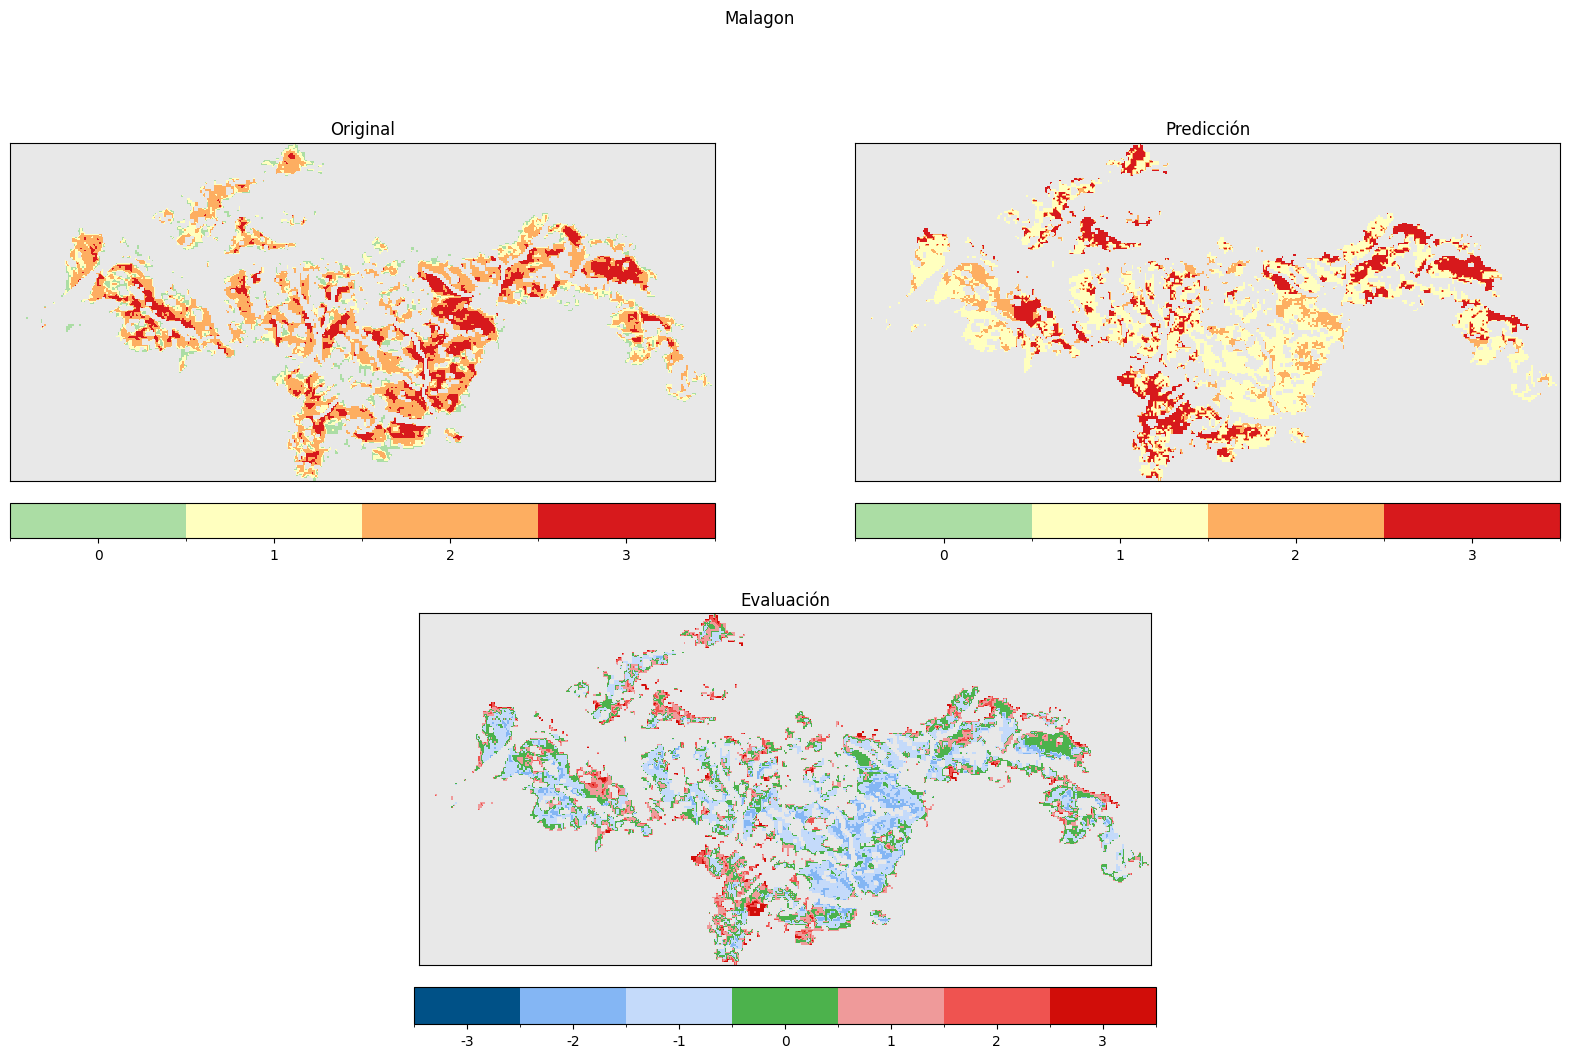

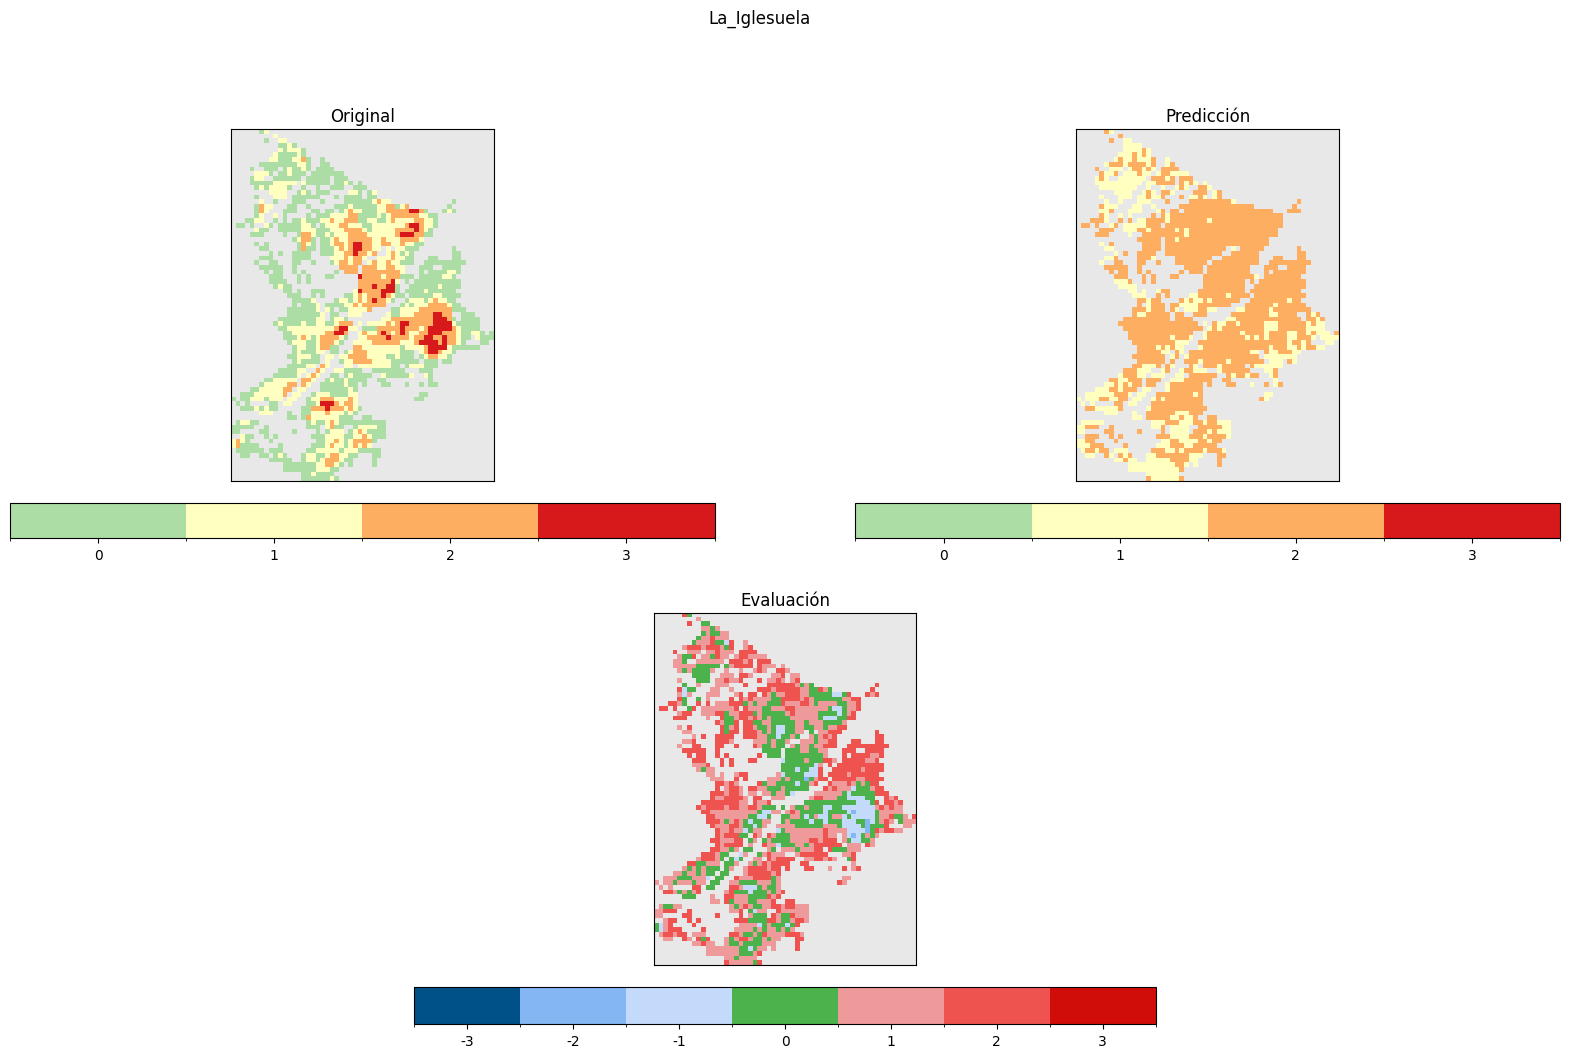

In [19]:
for fire_name in test_fire_names:
    df_fire = df_test[df_test['incendio'] == fire_name].reset_index(drop=True)

    X_fire = df_fire[variables]
    y_fire = df_fire[target_discrete]
    coords_fire = df_fire[coords_columns]

    pred = final_model['baja_alta'].predict(X_fire)
    predictions_baja_alta = pred
    pred_fire = np.zeros_like(predictions_baja_alta)

    if np.count_nonzero(predictions_baja_alta == 0) > 0:
        indexes_pred_baja = X_fire.index[predictions_baja_alta == 0]
        pred = final_model['baja_mediabaja'].predict(X_fire.loc[predictions_baja_alta == 0])


        predictions_baja_media = pred
        predictions_baja_media = np.where(predictions_baja_media == 0, 0, 1)
        pred_fire[indexes_pred_baja] = predictions_baja_media

    if np.count_nonzero(predictions_baja_alta == 1) > 0:
        indexes_pred_alta = X_fire.index[predictions_baja_alta == 1]
        pred = final_model['mediaalta_alta'].predict(X_fire.loc[predictions_baja_alta == 1])

        predictions_alta_muyalta = pred
        predictions_alta_muyalta = np.where(predictions_alta_muyalta == 0, 2, 3)
        pred_fire[indexes_pred_alta] = predictions_alta_muyalta

    matrix_fire = sm.get_severity_matrix(y_fire, coords_fire)
    matrix_pred = sm.get_severity_matrix(pred_fire, coords_fire)
    sm.show_original_prediction_evaluation_severity_matrices(matrix_fire, matrix_pred, fig_title=fire_name)